In [8]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
import os
import sys

sys.path.append(os.path.abspath('../frontend/src/plotting'))
sys.path.append(os.path.abspath('../backend/src/transform'))
sys.path.append(os.path.abspath('../backend/src/train'))
sys.path.append(os.path.abspath('../backend/src/data'))

import split_data, charts, metrics
from read_data import read_data

import matplotlib.pyplot as plt
import seaborn as sns

import optuna
from optuna.visualization.matplotlib import plot_param_importances
from optuna.visualization import plot_optimization_history
import shap

from lightgbm import LGBMRegressor

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

from tqdm import tqdm_notebook

import warnings
import yaml
import joblib
from typing import Any

warnings.filterwarnings('ignore')
pd.options.display.max_columns = 50
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [18]:
import warnings
import json
import re
from typing import Any, Tuple, Union
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.pipeline import Pipeline
from split_data import split_dataset_holdout

warnings.filterwarnings('ignore')


def transform_types(data: pd.DataFrame, types_dict: dict, err: str = 'raise',
                    object_to_category: bool = False) -> pd.DataFrame:
    '''
    Функция преобразования типов признаков в датасете.
    :param data: исходный датафрейм.
    :param types_dict: словарь с названиями признаков и их типами.
    :param err: параметр для вывода или игнорирования ошибок.
    :param object_to_category: трансформировать ли 'object' в 'category'.
    :return: трансформированный датафрейм.
    '''
    for col_name in types_dict.keys():
        if col_name in data.columns:
            data[col_name] = data[col_name].astype(types_dict[col_name], errors=err)
    if object_to_category:
        data[data.select_dtypes('object').columns] = data.select_dtypes('object').astype('category')
    return data


def modification_fill(mod_str: str) -> str:
    '''
    Функция для возврата подстроки из заданной строки.
    :param mod_str: значение признака.
    :return: подстрока с названием модификации.
    '''
    assert isinstance(mod_str, str), 'Проблема с данными на входе, mod_str должен быть str.'
    first_split = mod_str.split(',')[0]
    second_split = first_split.split()
    if '.' in first_split:
        return ' '.join(x for x in second_split[-2:])
    return second_split[-1]

def apply_function(function: Any, data: pd.DataFrame,
                   result_column: str, applying_column: str) -> pd.DataFrame:
    '''
    Функция для применения к признаку функции для его
    преобразования или заполнения пропусков.
    :param function: применяемая функция.
    :param data: исходный датафрейм.
    :param result_column: название признака, с которым работаем,
                          который получает изменения или заполнение.
    :param applying_column: название признака, по которому работает функция.
    :return: датафрейм с измененным признаком.
    '''
    assert isinstance(data, pd.DataFrame), 'Проблема с данными на входе, ' \
                                           'data должен быть pd.DataFrame.'
    assert isinstance(result_column, str), 'Проблема с данными на входе, ' \
                                           'result_column должен быть str.'
    assert isinstance(applying_column, str), 'Проблема с данными на входе, ' \
                                             'applying_column должен быть str.'
    data.loc[data[result_column].isna(), result_column] = \
        data.loc[data[result_column].isna(), applying_column].apply(function)
    return data


def anomaly_engine_volume(data: pd.DataFrame) -> pd.DataFrame:
    '''
    Замена выбросов в признаке Объём двигателя.
    :param data: исходный датафрейм.
    :return: датафрейм с измененным признаком.
    '''
    assert isinstance(data, pd.DataFrame), 'Проблема с данными на входе, ' \
                                           'data должен быть pd.DataFrame.'
    if data.loc[data['Объём_двигателя_л'] > 8, 'Объём_двигателя_л'].any():
        data.loc[data['Объём_двигателя_л'] > 8, 'Объём_двигателя_л'] = np.NaN
    else:
        pass
    return data


def clean_climate(data: pd.DataFrame) -> pd.DataFrame:
    '''
    Функция очистки признака Управление климатом от мусорных значений.
    :param data: исходный датафрейм.
    :return: очищенный датафрейм.
    '''
    mode_list = ['Климат-контроль многозонный', 'Кондиционер',
                 'Климат-контроль однозонный', 'Управление на руле',
                 'Атермальное остекление']
    data.loc[~data['Управление_климатом'].isin(mode_list),
             'Управление_климатом'] = 'Климат-контроль многозонный'
    return data


def column_mapper(data: pd.DataFrame, column_to_bin: str,
                  bins_dict: dict) -> pd.DataFrame:
    '''
    Замена значений в признаке по словарю.
    :param data: исходный датафрейм.
    :param column_to_bin: название признака для замены.
    :param bins_dict: словарь для замены значений.
    :return: датафрейм с бинаризованным признаком.
    '''
    assert isinstance(data, pd.DataFrame), 'Проблема с данными на входе, ' \
                                           'data должен быть pd.DataFrame.'
    data[column_to_bin] = data[column_to_bin].map(bins_dict)
    return data


def data_drop_poor_categories(data: pd.DataFrame) -> pd.DataFrame:
    '''
    Удаление объектов, имеющих всего 1 категорию в признаке Модификация.
    :param data: исходный датафрейм.
    :return: датафрейм с заполненным признаком.
    '''
    assert isinstance(data, pd.DataFrame), 'Проблема с данными на входе, ' \
                                           'data должен быть pd.DataFrame.'
    poor_categories = data['Модификация'].value_counts()[
                                                data['Модификация'].value_counts() < 2].index
    if len(poor_categories) > 0:
        data = data.loc[~data['Модификация'].isin(poor_categories)]
    else:
        pass
    return data


def many_owners_gen(data: pd.DataFrame) -> pd.DataFrame:
    '''
    Генерация признака Много владельцев.
    :param data: исходный датафрейм.
    :return: датафрейм с новым признаком.
    '''
    assert isinstance(data, pd.DataFrame), 'Проблема с данными на входе, ' \
                                           'data должен быть pd.DataFrame.'
    data['Много_владельцев'] = np.where(data['Владельцев_по_ПТС'] >= 4, 1, 0)
    return data


def service_life_gen(data: pd.DataFrame) -> pd.DataFrame:
    '''
    Генерация признака Срок эксплуатации.
    :param data: исходный датафрейм.
    :return: датафрейм с новым признаком.
    '''
    assert isinstance(data, pd.DataFrame), 'Проблема с данными на входе, ' \
                                           'data должен быть pd.DataFrame.'
    curr_year = datetime.now().year
    data['Срок_эксплуатации'] = curr_year - data['Год_выпуска']
    return data


def deterioration_bins_gen(data: pd.DataFrame,
                           bins: list, labels: list) -> pd.DataFrame:
    '''
    Генерация признака степень износа через формирование бинов по признаку Пробег.
    :param data: исходный датафрейм.
    :param bins: список с числовыми границами бинов.
    :param labels: наименование бинов.
    :return: датафрейм с новым признаком.
    '''
    assert isinstance(data, pd.DataFrame), 'Проблема с данными на входе, ' \
                                           'data должен быть pd.DataFrame.'
    data['Степень_износа'] = pd.cut(
        data['Пробег_км'],
        bins=bins,
        labels=labels)
    return data


def rename_columns(data: pd.DataFrame) -> pd.DataFrame:
    '''
    Переименование названий признаков в датафрейме,
    чтобы убрать мусорные символы и пробелы.
    :param data: исходный датафрейм.
    :return: датафрейм с переименованными признаками.
    '''
    assert isinstance(data, pd.DataFrame), 'Проблема с данными на входе, ' \
                                           'data должен быть pd.DataFrame.'
    data = data.rename(columns=lambda x: re.sub('[^A-Za-zА-яа-я0-9_-ё]+', '_', x))
    data['Поколение'] = data['Наименование_поколения']
    return data


def column_drop(data: pd.DataFrame, columns_list: list) -> pd.DataFrame:
    '''
    Удаление колонок.
    :param data: исходный датафрейм.
    :param columns_list: список с именами прознаков.
    :return: датафрейм без некоторых признаков.
    '''
    assert isinstance(data, pd.DataFrame), 'Проблема с данными на входе, ' \
                                           'data должен быть pd.DataFrame.'
    assert isinstance(columns_list, list), 'Проблема с данными на входе, ' \
                                           'columns_list должен быть list.'
    data = data.drop(columns_list, axis=1)
    return data


def data_fillna_train_test(data: pd.DataFrame, **kwargs) -> Tuple[pd.DataFrame, pd.DataFrame]:
    '''
    Заполнение пропусков в датасете, предварительно разделяя его на train и test.
    :param data: датасет.
    :return: train/test датасеты с заполненными данными.
    '''
    cat_columns = data.select_dtypes(include='object').columns
    num_columns = data.select_dtypes(exclude='object').columns
    strat_column = data[cat_columns].nunique().idxmin()
    df_train, df_test = split_dataset_holdout(dataset=data,
                                              stratify=data[strat_column],
                                              **kwargs)

    numeric_transformer = Pipeline(
        steps=[('imputer',
                IterativeImputer(estimator=RandomForestRegressor(
                    random_state=kwargs['random_state']),
                    max_iter=10,
                    random_state=kwargs['random_state']))])

    categorical_transformer = Pipeline(
        steps=[('imputer', SimpleImputer(strategy='most_frequent'))])

    preprocessor = ColumnTransformer(
        transformers=[('num', numeric_transformer,
                       num_columns), ('cat', categorical_transformer,
                                      cat_columns)])

    df_train = pd.DataFrame(preprocessor.fit_transform(df_train),
                            columns=num_columns.tolist() + cat_columns.tolist())
    df_test = pd.DataFrame(preprocessor.transform(df_test),
                           columns=num_columns.tolist() + cat_columns.tolist())
    for col in data.columns:
        df_train[col] = df_train[col].astype(data[col].dtype)
        df_test[col] = df_test[col].astype(data[col].dtype)

    return df_train, df_test


def save_unique_train_data(data: pd.DataFrame, drop_columns: list,
                              target_column: str, unique_values_path: str) -> None:
    '''
    Функция для сохранения уникальных наименований признаков.
    :param data: исходный датафрейм.
    :param drop_columns: список имен признаков для удаления.
    :param target_column: имя целевой переменной.
    :param unique_values_path: путь для сохранения.
    :return: не возвращает ничего.
    '''
    assert isinstance(data, pd.DataFrame), 'Проблема с данными на входе, ' \
                                           'data должен быть pd.DataFrame.'
    assert isinstance(drop_columns, list), 'Проблема с данными на входе, ' \
                                           'drop_columns должен быть list.'
    assert isinstance(target_column, str), 'Проблема с данными на входе, ' \
                                           'target_column должен быть str.'
    assert isinstance(unique_values_path, str), 'Проблема с данными на входе, ' \
                                                'unique_values_path должен быть str.'
    unique_data = data.drop(columns=drop_columns + [target_column], axis=1, errors='ignore')
    unique_dict = {key: unique_data[key].unique().tolist() for key in unique_data.columns}
    unique_dict['Год_выпуска'].sort()
    with open(unique_values_path, 'w', encoding='utf-8') as file:
        json.dump(unique_dict, file, ensure_ascii=False)


def save_cars_data(data: pd.DataFrame, cars_dict_path: str) -> None:
    '''
    Функция сохранения словаря с рейтингами автомобилей по их модификациям.
    :param data: датафрейм.
    :param cars_dict_path: путь до файла для сохранения.
    :return: None.
    '''
    assert isinstance(data, pd.DataFrame), 'Проблема с данными на входе, ' \
                                           'data должен быть pd.DataFrame.'
    grouped_df = data.groupby([
        'Бренд_авто', 'Модель_авто', 'Модификация', 'Поколение'
    ])['Рейтинг'].agg('mean').round(2).reset_index(name='Рейтинг')
    brand_dict = {
        key: grouped_df[grouped_df['Бренд_авто'] == key]
        ['Модель_авто'].unique().tolist()
        for key in grouped_df['Бренд_авто'].unique()
    }
    model_dict = {
        key: grouped_df[grouped_df['Модель_авто'] == key]
        ['Модификация'].unique().tolist()
        for key in grouped_df['Модель_авто'].unique()
    }
    gen_dict = {
        key: grouped_df[grouped_df['Модификация'] == key]
        ['Поколение'].unique().tolist()
        for key in grouped_df['Модификация'].unique().tolist()
    }
    rating_dict = {
        key: grouped_df[grouped_df['Поколение'] == key]
        ['Рейтинг'].values[0]
        for key in grouped_df['Поколение'].unique().tolist()
    }
    cars_dict = {
        'Бренды': brand_dict,
        'Модели': model_dict,
        'Поколения': gen_dict,
        'Рейтинги': rating_dict
    }
    with open(cars_dict_path, 'w', encoding='utf-8') as file:
        json.dump(cars_dict, file, ensure_ascii=False)



def check_columns_evaluate(data: pd.DataFrame, unique_values_path: str) -> pd.DataFrame:
    '''
    Проверка на соответствие признаков в train и test данных и их упорядочивание.
    :param data: тестовый датафрейм.
    :param unique_values_path: путь до файла с уникальными значениями.
    :return: тестовый датафрейм, прошедший проверку и упорядоченный.
    '''
    with open(unique_values_path, 'r', encoding='utf-8') as json_file:
        unique_values = json.load(json_file)
    columns_seq = unique_values.keys()
    assert set(data.columns) == set(columns_seq), 'Проверьте признаки в ' \
                                                  'тренировочных и тестовых данных.'
    return data[columns_seq]


def preprocessing_pipeline(data: pd.DataFrame, flg_evaluate: bool = True,
                           save_csv=False, **kwargs) -> \
        Union[pd.DataFrame, Tuple[pd.DataFrame, pd.DataFrame]]:
    '''
    Конвеер для препроцессинга данных для трансформирования их в удобный рабочий вид.
    :param data: исходный датафрейм.
    :param flg_evaluate: флаг проверки соответствия признаков.
    :param kwargs: дополнительные параметры из конфигурации.
    :return: два трансформированных датафрейма train/test.
    '''
    if (data.isna().sum().sum() > 0) or ('Название авто' in data.columns):
        data = rename_columns(data=data)
        data = apply_function(function=modification_fill,
                              data=data,
                              result_column='Модификация',
                              applying_column='Название_авто')
        data = anomaly_engine_volume(data=data)
        data = clean_climate(data=data)
        data = column_drop(data=data, columns_list=kwargs['drop_columns'])
        data = data_drop_poor_categories(data=data)
        df_train, df_test = data_fillna_train_test(data=data, **kwargs)
        for dataframe in (df_train, df_test):
            dataframe = column_mapper(data=dataframe,
                                      column_to_bin='Обмен',
                                      bins_dict=kwargs['map_change_columns']['Обмен'])
            dataframe = many_owners_gen(data=dataframe)
            dataframe = service_life_gen(data=dataframe)
            dataframe = deterioration_bins_gen(data=dataframe,
                                               bins=kwargs['map_bins']['Пробег_км']['bins'],
                                               labels=kwargs['map_bins']['Пробег_км']['labels'])
            dataframe = transform_types(data=dataframe,
                                        types_dict=kwargs['change_type_columns'],
                                        err='raise',
                                        object_to_category=True)
        if save_csv:
            df_train.to_csv(kwargs['train_path_proc'], index=False)
            df_test.to_csv(kwargs['test_path_proc'], index=False)
    else:
        data = transform_types(data=data,
                               types_dict=kwargs['change_type_columns'],
                               err='raise',
                               object_to_category=True)
    if flg_evaluate:
        check_columns_evaluate(data=data, unique_values_path=kwargs['unique_values_path'])
        return data
    else:
        save_unique_train_data(data=df_train,
                               drop_columns=kwargs['drop_columns'],
                               target_column=kwargs['target_column'],
                               unique_values_path=kwargs['unique_values_path'])
        save_cars_data(data=df_train, cars_dict_path=kwargs['cars_dict_path'])
        return df_train, df_test


In [19]:
train, test = preprocessing_pipeline(df, flg_evaluate=False, **preproc)

MemoryError: Unable to allocate 12.4 GiB for an array with shape (13298406660,) and data type int8

# Описание задачи.

Данные получены при помощи парсинга сайта avito.ru. Необходимо создать модель, способную по характеристикам автомобиля и дополнительным параметрам предсказать его цену. 

**Данные по автомобилям:**

Целевая переменная - Цена.

- Рейтинг - рейтинг автомобиля на сайте.
- Год выпуска - год производства автомобиля.
- Поколение - поколение автомобиля.
- Пробег, км - сколько проехал автомобиль в километрах.
- История пробега, кол-во записей - количество записей об истории пробега в автотеке. 
- Владельцев по ПТС - количество владельцев, записанных в ПТС.
- Состояние - общее состояние автомобиля.
- Модификация - модификация автомобиля.
- Объём двигателя, л - объём двигателя в литрах.
- Тип двигателя - тип двигателя.
- Коробка передач - тип коробки передач.
- Привод - тип привода.
- Комплектация - комплектация автомобиля
- Тип кузова - тип кузова автомобиля.
- Цвет - цвет автомобиля.
- Руль - расположение руля.
- Управление климатом - тип системы управления климатом
- ПТС - вид ПТС.
- Обмен - рассматривается ли обмен автомобиля на другой, или альтернативные варианты.
- Бренд авто - наименование бренда авто, производитель.
- Модель авто - наименование модели авто.
- Город - город, в котором продаётся авто.
- Регион - регион, в котором продаётся авто.
- Выпуск, кол-во лет - количество лет, в течение которого шёл выпуск автомобиля
- Мощность двигателя, лс - мощность двигателя автомобиля, в лошадиных силах.

In [13]:
config_path = '../config/parameters.yml'
config = yaml.load(open(config_path, 'r', encoding='utf-8'), 
                   Loader=yaml.FullLoader)

preproc = config['preprocessing']
train = config['train']

In [14]:
df = read_data(preproc['raw_data_path'])
df[:5]

,Название авто,Рейтинг,Цена,Расположение,Год выпуска,Поколение,"Пробег, км","История пробега, кол-во записей",Владельцев по ПТС,Состояние,Модификация,"Объём двигателя, л",Тип двигателя,Коробка передач,Привод,Комплектация,Тип кузова,Цвет,Руль,Управление климатом,ПТС,Обмен,Бренд авто,Модель авто,Город,Федеральный округ,Наименование поколения,"Выпуск, кол-во лет","Мощность двигателя, лс"
0,"Audi Q3 2.0 AMT, 2013, 166 000 км",4.8,1745000,"Самарская обл., Самара, Московское ш., 262А",2013.0,I (2011—2014),166000.0,11.0,3.0,Не битый,2.0 TFSI quattro S tronic,2.0,Бензин,Робот,Полный,Базовая,Внедорожник 5-дверный,Чёрный,Левый,NaN,NaN,NaN,Audi,Q3,Самара,Приволжский,I,3.0,170.0
1,"Audi Q7 3.0 AT, 2021, 29 226 км",5.0,8785500,"Москва, Волоколамское ш., 73",2021.0,4M рестайлинг (2019—2024),29226.0,2.0,1.0,Не битый,45 TDI 3.0 quattro Tiptronic,3.0,Дизель,Автомат,Полный,Sport,Внедорожник 5-дверный,Чёрный,Левый,Климат-контроль многозонный,NaN,NaN,Audi,Q7,Волоколамск,Центральный,4M рестайлинг,5.0,249.0
2,"Audi Q8 3.0 AT, 2022, 100 км",5.0,11200000,"Москва, ул. Верхние Поля, 2",2022.0,I (2018—2023),100.0,3.0,1.0,Не битый,55 TFSI 3.0 quattro Tiptronic,3.0,Бензин,Автомат,Полный,Advance,Внедорожник 5-дверный,Чёрный,Левый,Климат-контроль многозонный,Электронный,Не интересует,Audi,Q8,Москва,Центральный,I,5.0,340.0
3,"Audi Q7 3.0 AT, 2013, 151 488 км",4.8,2099000,"Санкт-Петербург, пр-т Маршала Жукова, 78",2013.0,4L рестайлинг (2009—2015),151488.0,15.0,2.0,Не битый,3.0 TDI quattro Tiptronic,3.0,Дизель,Автомат,Полный,NaN,Внедорожник 5-дверный,Белый,Левый,Климат-контроль многозонный,NaN,Возможен,Audi,Q7,Жуков,Центральный,4L рестайлинг,6.0,245.0
4,"Audi Q8 3.0 AT, 2022, 3 261 км",5.0,10400000,"Москва, Бережковская наб., 38с2",2022.0,I (2018—2023),3261.0,NaN,1.0,Не битый,50 TDI 3.0 quattro Tiptronic,3.0,Дизель,Автомат,Полный,Базовая,Внедорожник 5-дверный,Красный,Левый,NaN,NaN,NaN,Audi,Q8,Москва,Центральный,I,5.0,286.0


In [18]:
np.round(df['Объём двигателя, л'].mean(), 1)

10.9

In [13]:
df[df['Объём двигателя, л'] > 20]

,Название авто,Рейтинг,Цена,Расположение,Год выпуска,Поколение,"Пробег, км","История пробега, кол-во записей",Владельцев по ПТС,Состояние,Модификация,"Объём двигателя, л",Тип двигателя,Коробка передач,Привод,Комплектация,Тип кузова,Цвет,Руль,Управление климатом,ПТС,Обмен,Бренд авто,Модель авто,Город,Федеральный округ,Наименование поколения,"Выпуск, кол-во лет","Мощность двигателя, лс"
12565,"Haval F7x, 2023 Новый",4.6,2953000,"Челябинская обл., Челябинск, Свердловский трак...",2023.0,I рестайлинг (2022—2024),NaN,NaN,NaN,Не битый,2.0 4WD AMT,331805.0,Бензин,Робот,Полный,Tech Plus,Внедорожник 5-дверный,Белый,Левый,NaN,NaN,NaN,Haval,F7x,Челябинск,Уральский,I рестайлинг,2.0,190.0


In [7]:
df_new = preprocessing_pipeline(df, flg_evaluate=False, **preproc)

In [9]:
df_new.describe()

,Рейтинг,Цена,Год_выпуска,Пробег_км,История_пробега_кол_во_записей,Владельцев_по_ПТС,Объём_двигателя_л,Обмен,Выпуск_кол_во_лет,Мощность_двигателя_лс,Много_владельцев,Срок_эксплуатации
count,35700.000000,3.570000e+04,35700.000000,35700.000000,35700.000000,35700.000000,35700.000000,35700.000000,35700.000000,35700.000000,35700.000000,35700.000000
mean,4.665229,1.466917e+06,2012.603697,152134.656218,8.687507,2.345938,11.263987,0.296975,5.091541,150.137759,0.237843,11.396303
std,0.236971,1.087772e+06,7.539260,107790.302610,7.772512,1.178032,1756.071777,0.456932,3.363522,60.189788,0.425769,7.539260
min,2.900000,1.000000e+03,1934.000000,1.000000,0.000000,1.000000,0.600000,0.000000,1.000000,33.000000,0.000000,0.000000
25%,4.600000,6.135748e+05,2008.000000,73000.000000,3.000000,1.000000,1.600000,0.000000,3.000000,107.000000,0.000000,5.000000
50%,4.700000,1.150000e+06,2012.000000,150356.500000,8.000000,2.000000,1.800000,0.000000,4.000000,141.000000,0.000000,12.000000
75%,4.800000,2.095000e+06,2019.000000,216406.750000,12.000000,3.000000,2.000000,1.000000,6.000000,181.000000,0.000000,16.000000
max,5.000000,4.785000e+06,2024.000000,1000000.000000,99.000000,4.000000,331805.000000,1.000000,42.000000,585.000000,1.000000,90.000000


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37568 entries, 0 to 37567
Data columns (total 29 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   Название авто                    37568 non-null  category
 1   Рейтинг                          36861 non-null  float32 
 2   Цена                             37568 non-null  int32   
 3   Расположение                     37568 non-null  category
 4   Год выпуска                      37568 non-null  float64 
 5   Поколение                        37568 non-null  category
 6   Пробег, км                       33530 non-null  float64 
 7   История пробега, кол-во записей  31357 non-null  float64 
 8   Владельцев по ПТС                33530 non-null  float64 
 9   Состояние                        37568 non-null  category
 10  Модификация                      37524 non-null  category
 11  Объём двигателя, л               37442 non-null  float64 
 12  Тип 

In [5]:
df.describe()

,Рейтинг,Цена,Год выпуска,"Пробег, км","История пробега, кол-во записей",Владельцев по ПТС,"Объём двигателя, л","Выпуск, кол-во лет","Мощность двигателя, лс"
count,36861.000000,3.756800e+04,37568.000000,33530.000000,31357.000000,33530.000000,37442.000000,37567.000000,37524.000000
mean,4.667266,1.850526e+06,2012.975405,164820.118729,9.979335,2.444885,10.873791,5.053984,157.933509
std,0.239775,2.405473e+06,7.562925,100777.927822,7.753059,1.161670,1714.749998,3.311197,71.742503
min,2.600000,1.000000e+03,1934.000000,1.000000,0.000000,1.000000,0.600000,1.000000,33.000000
25%,4.600000,6.400000e+05,2008.000000,93827.500000,5.000000,1.000000,1.600000,3.000000,109.000000
50%,4.700000,1.239000e+06,2013.000000,160000.000000,9.000000,2.000000,1.800000,4.000000,143.000000
75%,4.800000,2.299000e+06,2019.000000,221000.000000,13.000000,4.000000,2.200000,6.000000,186.000000
max,5.000000,4.800000e+07,2024.000000,1000000.000000,99.000000,4.000000,331805.000000,42.000000,802.000000


In [6]:
df.describe(include='object')

,Название авто,Расположение,Поколение,Состояние,Модификация,Тип двигателя,Коробка передач,Привод,Комплектация,Тип кузова,Цвет,Руль,Управление климатом,ПТС,Обмен,Бренд авто,Модель авто,Город,Федеральный округ,Наименование поколения
count,37568,37568,37568,37568,37524,37568,37568,37568,30290,37457,37568,37568,20889,26996,30753,37568,37568,36167,36167,37567
unique,31516,20421,1479,2,1503,5,4,3,904,13,17,2,11,3,2,28,896,653,8,586
top,"EXEED RX 2.0 AMT, 2023 Новый","Санкт-Петербург, ул. Дыбенко, 26",I (2022—2024),Не битый,1.6 MT,Бензин,Автомат,Передний,Базовая,Внедорожник 5-дверный,Белый,Левый,Климат-контроль многозонный,Оригинал,Не интересует,Renault,Focus,Москва,Центральный,I
freq,192,139,767,37061,4447,32414,16107,22550,10771,14764,9185,36337,10791,18133,21468,1742,815,4239,12719,10735


Выводы:

- Достаточно много категориальных признаков, а также пропусков в данных.
- Подавляющее большинство автомобилей в выборке с бензиновым типом двигателя.
- Большинство авто леворульные, что характерно для России.
- В среднем возраст продаваемых авто 10 лет, но есть авто с годом выпуска 1949, что очень похоже на выброс.
- В среднем каждая модель определённого поколения выпускается около 5 лет, есть авто с длиной выпуска модели 42 года, что тоже очень похоже на выброс.
- Признак владельцев по ПТС нужно будет разбить на бины, т. к. при первичной очистке мы заменяли строковое значение "4+", которое подразумевает больше 4, на целочисленное 4. Как раз напрашиваются 2 бина: много - мало, больше 4 и меньше 4.
- Почти все авто продаются в "не битом" состоянии. Большая часть в Центральном регионе России.
- Есть авто с 1 км пробега, что тоже похоже на выброс. В среднем все представленные авто ездят около 160 тыс. км. У авито есть архив по пробегу называемый автотека, присутствует авто с более чем 99 записями - скорее всего тоже выброс.
- Интересно, что большинство и не заинтересованы в обмене авто, а только в его продажи, достаточно много людей готовы рассмотреть обмен как альтернативу.

# Гипотезы.

Посмотрим на общее количество автомобилей по брендам, а также на числовые признаки поближе.

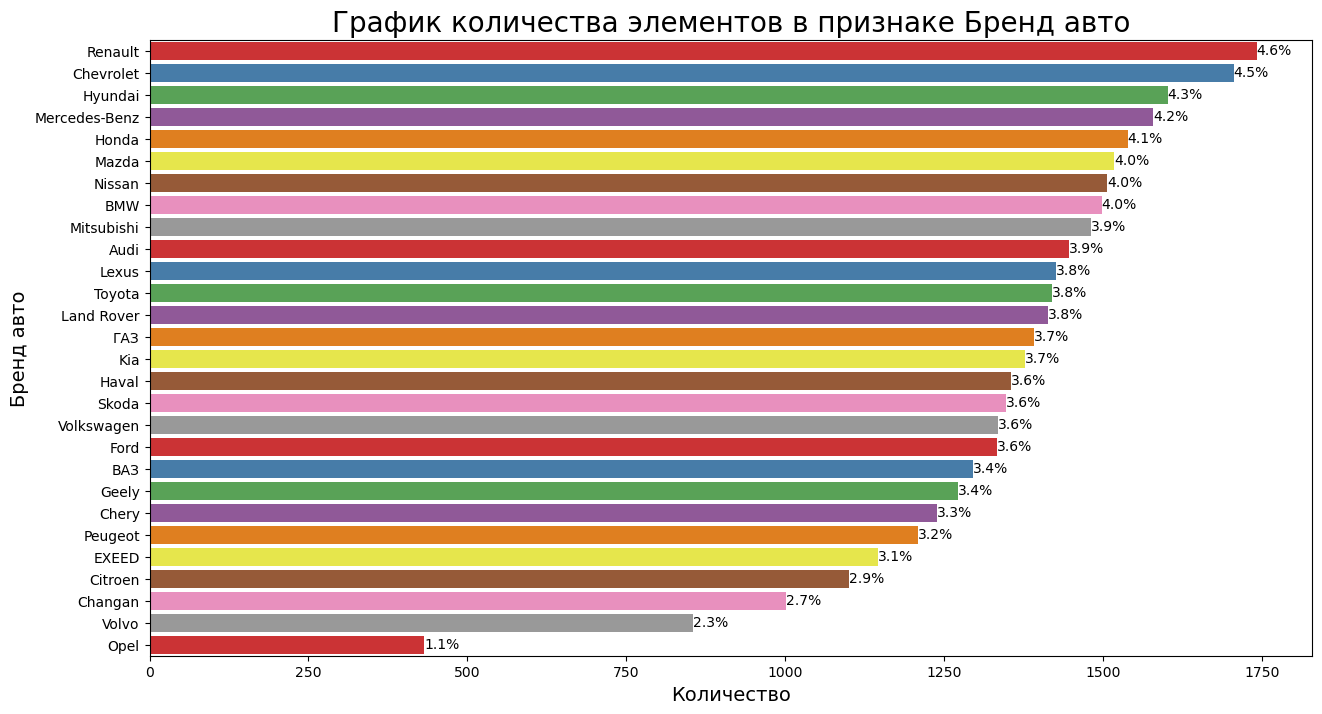

In [7]:
charts.plot_countplot(df, 'Бренд авто')

В целом в каждом бренде, кроме Opel, достаточно много автомобилей.

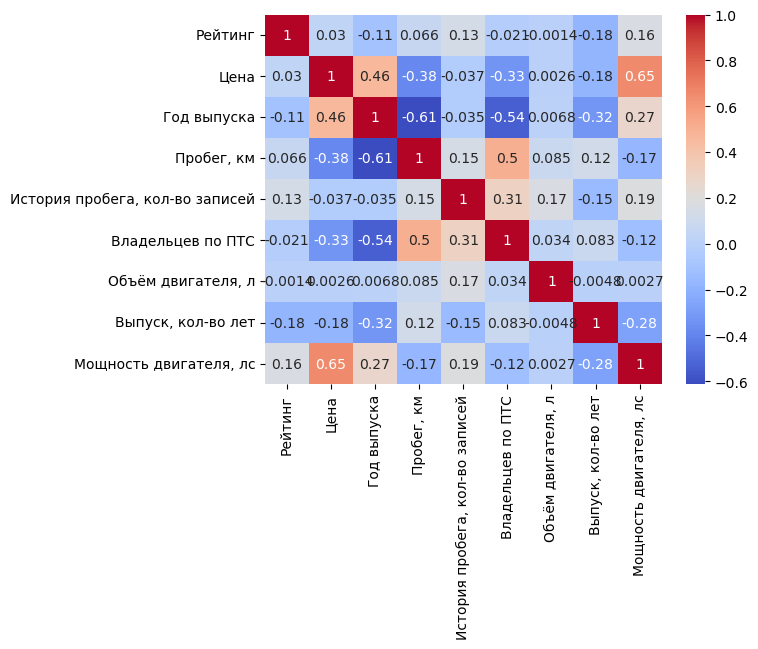

In [8]:
sns.heatmap(df.select_dtypes(exclude='object').corr(),
            cmap='coolwarm',
            annot=True);

Как видим, сильно скореллированных признаков нет. Самая большая корреляция у объёма и мощности двигателя, это и логично, больше литров = больше лошадей. Но самое интересное, что наша целевая переменная Цена коррелирует больше всего с мощностью и годом выпуска, и только потом уже объём двигателя, а так же, чем больше в ПТС владельцев, тем хуже это будет сказываться на Цене - достаточно выраженная обратная корреляция. Также наблюдается выраженная обратная корреляция у года выпуска и пробега - чем больше пробег, тем меньше год выпуска.

**Гипотеза 1**: есть бренды, которые продаются дороже относительно других. Поэтому стоит рассматривать определённый бренд авто в зависимости от дохода покупателя.

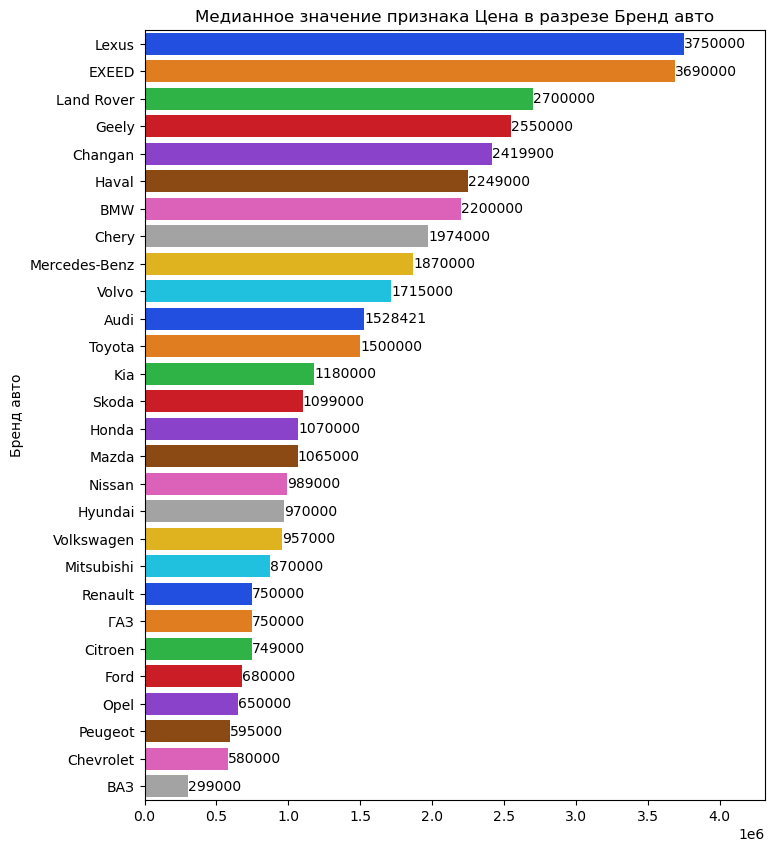

In [9]:
charts.plot_median_barplot(df, 'Бренд авто', 'Цена')

Так как брендов много, поделим их на 3 части.

In [10]:
brand_list = list(df['Бренд авто'].value_counts().index)
first_part = df.loc[df['Бренд авто'].isin(brand_list[:9])]
second_part = df.loc[df['Бренд авто'].isin(brand_list[9:18])]
third_part = df.loc[df['Бренд авто'].isin(brand_list[18:])]

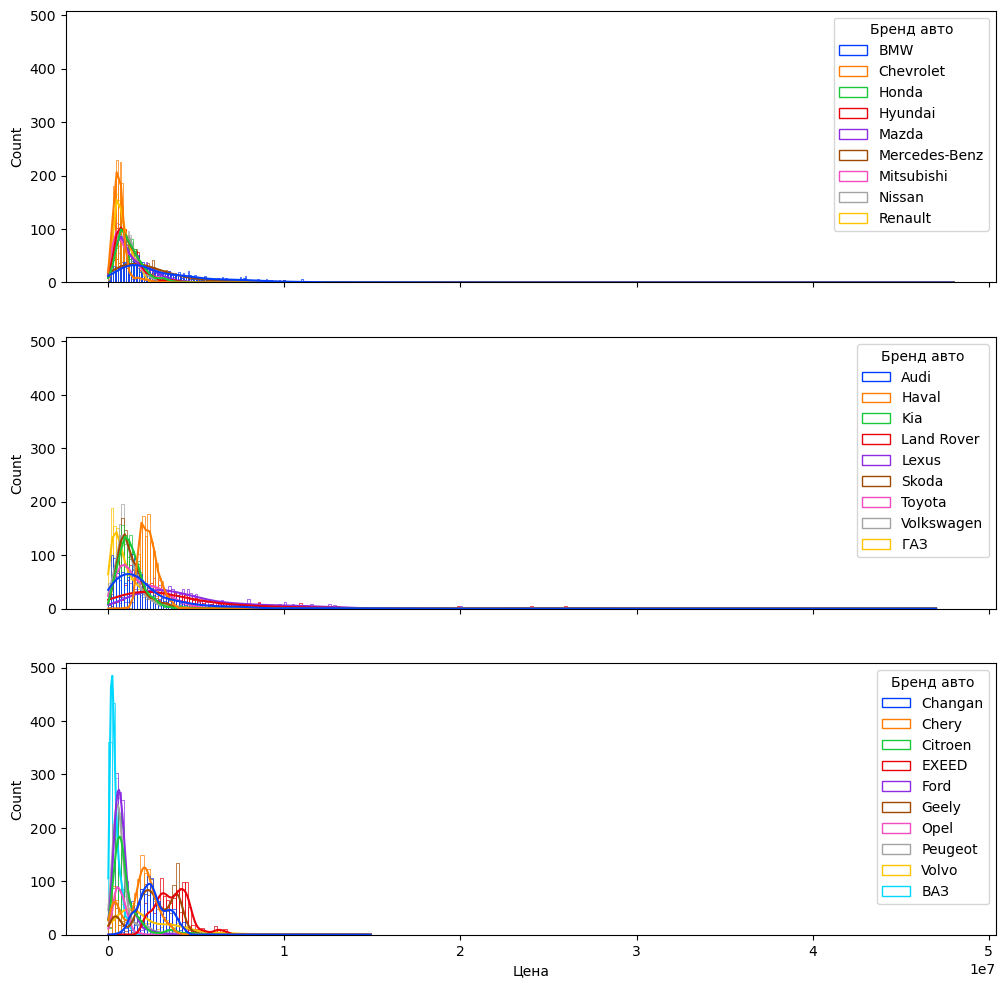

In [11]:
fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True, sharey=True)

for ax, data_part in zip(axes.flat, (first_part, second_part, third_part)):
    sns.histplot(data=data_part,
                 x='Цена',
                 hue='Бренд авто',
                 fill=False,
                 kde=True,
                 palette='bright',
                 ax=ax)

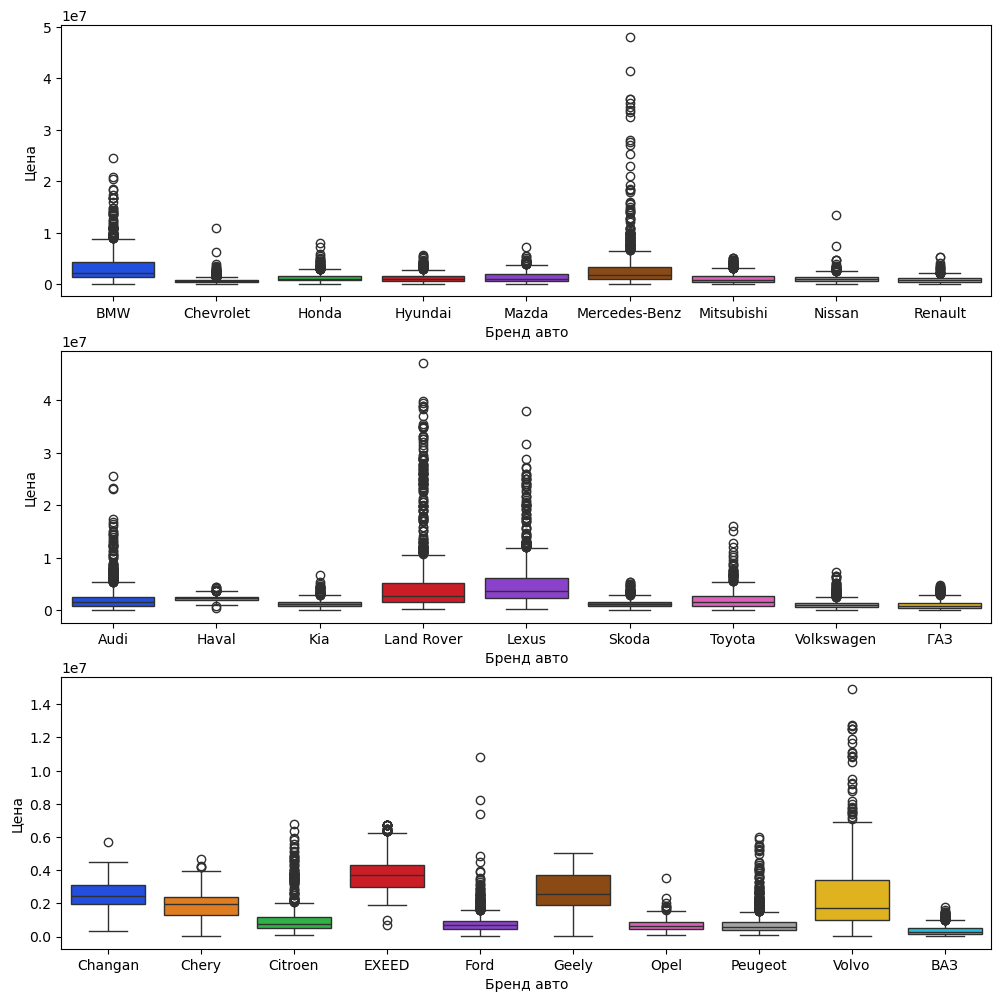

In [12]:
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

for ax, data_part in zip(axes.flat, (first_part, second_part, third_part)):
    sns.boxplot(data=data_part,
                x='Бренд авто',
                y='Цена',
                hue='Бренд авто',
                palette='bright',
                ax=ax)

**Гипотеза подтвердилась.** Стабильно дороже стоят EXCEED и Lexus, хоть они и уступают объёму предложения. Но если брать в рассчёт экстремальные значения, то видим, что есть цены на Audi, BMW, Lexus, Land Rover и Mercedes которые сильно выходят за рамки межквартильного размаха, и интерпретируются как выбросы.

**Гипотеза 2:** У любого бренда автомобиля в линейке моделей можно найти все типы коробок передач. Вдруг у потенциального покупателя есть предпочтения, например "хочу только автомат", или "только не робот или вариатор, они часто ломаются, или сбоят".

Посмотрим на доли типов коробок передач в разрезе брендов.

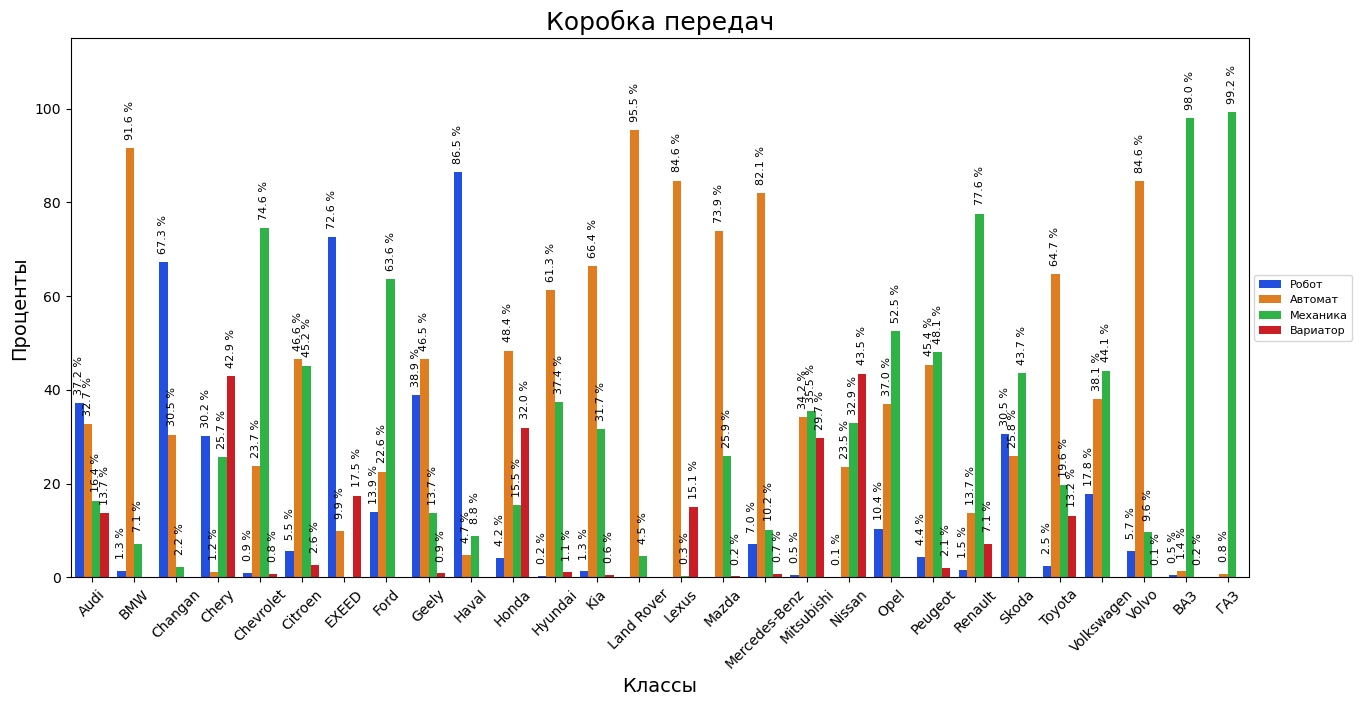

In [13]:
plt.figure(figsize=(19, 7))

charts.plot_bars(df=df, target='Бренд авто', feature='Коробка передач')

**Гипотеза не подтвердилась.** У каждого из брендов преобладает свой тип коробки, например Автомат у Lexus, или Робот у Haval, отечественный автопром так и вовсе почти весь оказался на Механике. У брендов Audi, Chery, Citroen, Geely, Honda, Peugeot, Renault и Toyota есть модели со всеми типами коробок.

**Гипотеза 3:** автомобили в любой части России стоят +- одинаково. Нет необходимости ехать далеко за более привлекательной ценой.

<Figure size 1200x800 with 0 Axes>

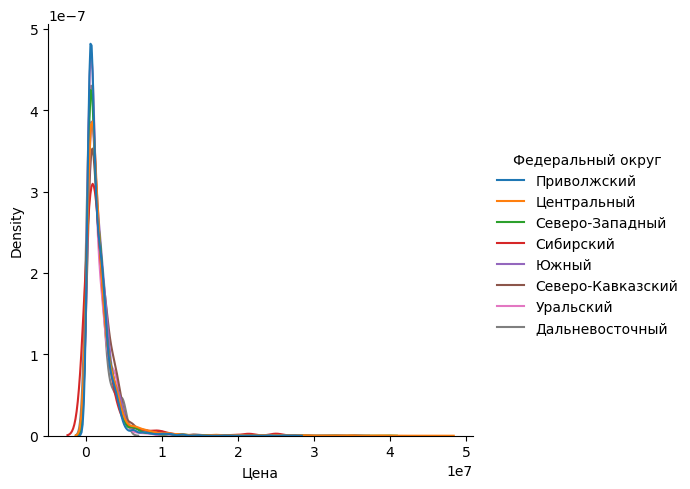

In [14]:
plt.figure(figsize=(12, 8))

sns.displot(data=df,
            x='Цена',
            hue='Федеральный округ',
            kind='kde',
            common_norm=False);

**Гипотеза подтвердилась.** Сильных различий между ценами авто в разных ФО не наблюдается. Но опять же есть нюанс - это если мы рассматриваем просто автомобиль, без каких то специфичных запросов и характеристик.

**Гипотеза 4:** в Центральном ФО сосредоточено самое большое количество автомобилей. Если ехать выбирать, то почти все бренды можно найти практически в одном месте.

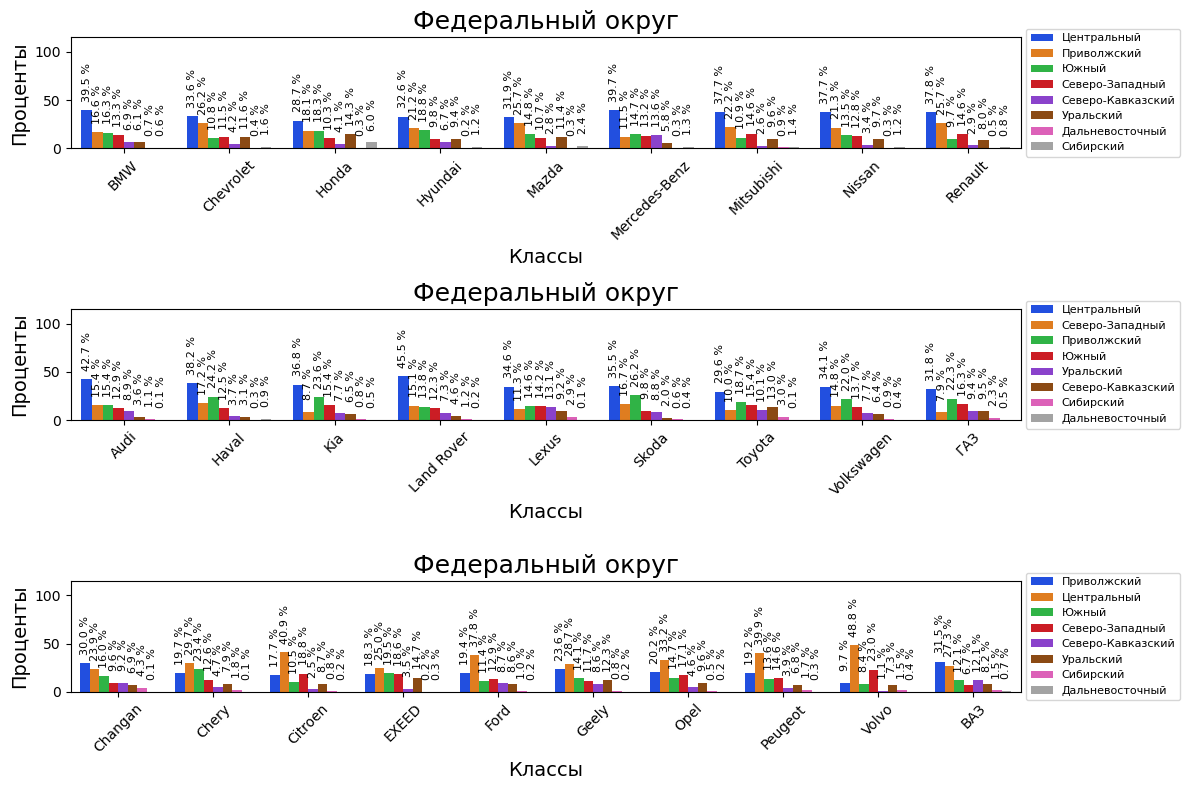

In [15]:
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharey=True)

for ax, data_part in zip(axes.flat, (first_part, second_part, third_part)):
    charts.plot_bars(df=data_part,
                     target='Бренд авто',
                     feature='Федеральный округ',
                     ax=ax)
    plt.tight_layout()

**Гипотеза подтвердилась**: самые крупные регионы по количеству автомобилей - это Центральный и Приволжский.

**Гипотеза 5:** каждый бренд авто делает упор на какой-то конкретный тип привода. Если мы захотим полноприводный внедорожник, то будем смотреть определённые бренды, а не все подряд.

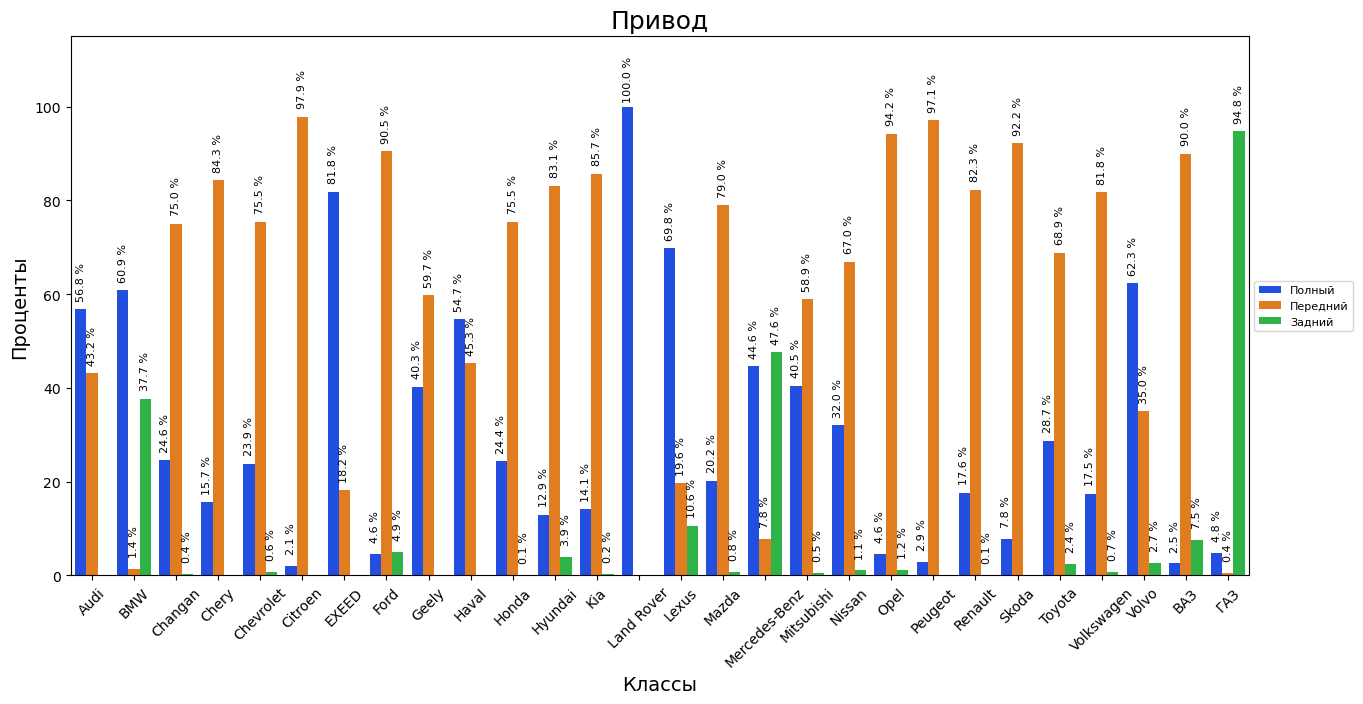

In [16]:
plt.figure(figsize=(19, 7))

charts.plot_bars(df=df, target='Бренд авто', feature='Привод')

**Гипотеза частично подтвердилась.** Бренды сильно различаются по тому, какие типы приводов используются в их линейках авто, но мало кто фокусируется на каком то одном. Land Rover, ГАЗ, Citroen - больше используют какой-то 1 тип. А вот в остальных приводы распределились совершенно по разному.

# Feature Engineering.

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37568 entries, 0 to 37567
Data columns (total 29 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Название авто                    37568 non-null  object 
 1   Рейтинг                          36861 non-null  float64
 2   Цена                             37568 non-null  int64  
 3   Расположение                     37568 non-null  object 
 4   Год выпуска                      37568 non-null  float64
 5   Поколение                        37568 non-null  object 
 6   Пробег, км                       33530 non-null  float64
 7   История пробега, кол-во записей  31357 non-null  float64
 8   Владельцев по ПТС                33530 non-null  float64
 9   Состояние                        37568 non-null  object 
 10  Модификация                      37524 non-null  object 
 11  Объём двигателя, л               37442 non-null  float64
 12  Тип двигателя     

Первым делом разберёмся с пропусками. С каждым признаком придётся поработать достаточно кропотливо.

## Модификация.

Начнём с признака Модификация, так как по нему можно будет заполнить Рейтинг.

In [18]:
df[~df['Модификация'].isna()][10:50]

,Название авто,Рейтинг,Цена,Расположение,Год выпуска,Поколение,"Пробег, км","История пробега, кол-во записей",Владельцев по ПТС,Состояние,Модификация,"Объём двигателя, л",Тип двигателя,Коробка передач,Привод,Комплектация,Тип кузова,Цвет,Руль,Управление климатом,ПТС,Обмен,Бренд авто,Модель авто,Город,Федеральный округ,Наименование поколения,"Выпуск, кол-во лет","Мощность двигателя, лс"
10,"Audi Q8 3.0 AT, 2023 Новый",NaN,17450000,"Москва, МКАД, 51-й километр, 10",2023.0,I рестайлинг (2023—2024),NaN,NaN,NaN,Не битый,50 TDI 3.0 quattro Tiptronic,3.0,Дизель,Автомат,Полный,Базовая,Внедорожник 5-дверный,Чёрный,Левый,Климат-контроль многозонный,NaN,NaN,Audi,Q8,Москва,Центральный,I рестайлинг,1.0,286.0
11,"Audi Q5 2.0 AMT, 2011, 218 225 км",4.5,1475000,"Московская обл., Подольск, пр-т Юных Ленинцев, 1И",2011.0,I (2008—2012),218225.0,13.0,3.0,Не битый,2.0 TDI quattro S tronic,2.0,Дизель,Робот,Полный,Базовая,Внедорожник 5-дверный,Серебряный,Левый,Климат-контроль многозонный,NaN,Возможен,Audi,Q5,Подольск,Центральный,I,4.0,170.0
12,"Audi Q2 1.5 AMT, 2021, 2 404 км",NaN,3449000,"Санкт-Петербург, Стартовая ул., 10",2021.0,I рестайлинг (2020—2024),2404.0,5.0,1.0,Не битый,35 TFSI 1.5 S tronic,1.5,Бензин,Робот,Передний,Базовая,Внедорожник 5-дверный,Белый,Левый,Климат-контроль многозонный,NaN,Возможен,Audi,Q2,Санкт-Петербург,Северо-Западный,I рестайлинг,4.0,150.0
13,"Audi Q7 3.0 AT, 2020, 130 000 км",5.0,6990000,"Москва, Каширское ш., 148к3",2020.0,4M рестайлинг (2019—2024),130000.0,0.0,1.0,Не битый,45 TDI 3.0 quattro Tiptronic,3.0,Дизель,Автомат,Полный,NaN,Внедорожник 5-дверный,Белый,Левый,NaN,Электронный,Не интересует,Audi,Q7,Москва,Центральный,4M рестайлинг,5.0,249.0
14,"Audi Q5 Sportback 2.0 AMT, 2022, 50 км",NaN,8349900,"Московская обл., Балашиха, территория Западная...",2022.0,FY (2020—2024),50.0,0.0,1.0,Не битый,40 TDI 2.0 quattro S tronic,2.0,Дизель,Робот,Полный,Базовая,Внедорожник 5-дверный,Чёрный,Левый,Климат-контроль многозонный,NaN,Возможен,Audi,Q5 Sportback,Балашиха,Центральный,FY,4.0,204.0
15,"Audi Q3 2.0 AMT, 2014, 85 958 км",4.8,2158000,"Москва, Михайловский пр., 3с2",2014.0,I (2011—2014),85958.0,5.0,2.0,Не битый,2.0 TFSI quattro S tronic,2.0,Бензин,Робот,Полный,Базовая,Внедорожник 5-дверный,Чёрный,Левый,NaN,NaN,Возможен,Audi,Q3,Михайлов,Центральный,I,3.0,170.0
16,"Audi A5 1.8 CVT, 2013, 137 322 км",4.6,1499000,"Москва, Нововладыкинский пр., 2с1",2013.0,I рестайлинг (2011—2016),137322.0,11.0,2.0,Не битый,1.8 TFSI Multitronic,1.8,Бензин,Вариатор,Передний,NaN,Купе,Серебряный,Левый,Климат-контроль однозонный,NaN,Возможен,Audi,A5,Москва,Центральный,I рестайлинг,5.0,170.0
17,"Audi Q5 2.0 AT, 2014, 114 000 км",4.7,1649000,"Москва, Варшавское ш., 125с1В",2014.0,I рестайлинг (2012—2017),114000.0,16.0,2.0,Не битый,2.0 TFSI quattro Tiptronic,2.0,Бензин,Автомат,Полный,NaN,Внедорожник 5-дверный,Белый,Левый,Климат-контроль многозонный,NaN,Возможен,Audi,Q5,Москва,Центральный,I рестайлинг,5.0,225.0
18,"Audi A3 1.4 AMT, 2013, 145 000 км",4.7,1190000,"Санкт-Петербург, Таллинское ш., 202",2013.0,8V (2012—2016),145000.0,9.0,3.0,Не битый,1.4 TFSI S tronic,1.4,Бензин,Робот,Передний,NaN,Хетчбек 5-дверный,Белый,Левый,Климат-контроль многозонный,NaN,NaN,Audi,A3,Санкт-Петербург,Северо-Западный,8V,4.0,122.0
19,"Audi RS Q8 4.0 AT, 2019, 8 987 км",5.0,15090000,"Московская обл., Балашиха, территория Западная...",2019.0,I (2019—2024),8987.0,2.0,1.0,Не битый,4.0 TFSI quattro Tiptronic,4.0,Бензин,Автомат,Полный,Quattro,Внедорожник 5-дверный,Оранжевый,Левый,Климат-контроль многозонный,NaN,NaN,Audi,RS Q8,Балашиха,Центральный,I,5.0,600.0


Как видим, модификация есть в названии авто, если это не что-то специфичное. Например в строке "Mazda 3 2.5 AT, 2021, 31 000 км	" модификацией будет 2.5 AT.

In [19]:
def modification_fill(mod_str: str) -> str:
    '''Функция для возврата подстроки из заданной строки. '''
    first_split = mod_str.split(',')[0]
    second_split = first_split.split()
    if '.' in first_split:
        return ' '.join(x for x in second_split[-2:])
    else:
        return second_split[-1]       

In [20]:
df.loc[df['Модификация'].isna(), 'Модификация'] = df[
    df['Модификация'].isna()]['Название авто'].apply(modification_fill)

In [21]:
df['Модификация'].isna().sum()

0

## Рейтинг.

Пропущенные значения в рейтинге будем заполнять по теперь уже известной Модификации, так как это будет максимально близко к реальности.

In [22]:
df['Рейтинг'].isna().sum()

707

In [23]:
mean_rating = df.groupby('Модификация')['Рейтинг'].transform('mean')
df['Рейтинг'] = df['Рейтинг'].fillna(mean_rating)

In [24]:
df['Рейтинг'].isna().sum()

155

Всеравно остались пропуски, их заполним средним по бренду.

In [25]:
mean_rating_brand = df.groupby('Бренд авто')['Рейтинг'].transform('mean')
df['Рейтинг'] = df['Рейтинг'].fillna(mean_rating_brand)

In [26]:
df['Рейтинг'].isna().sum()

0

## Пробег.

С пробегом будем работать по году выпуска, заполним медианным значением.

In [27]:
df['Год выпуска'] = df['Год выпуска'].astype('int32')
median_mileage = df.groupby('Год выпуска')['Пробег, км'].transform('median')
df['Пробег, км'] = df['Пробег, км'].fillna(median_mileage)

In [28]:
df['Пробег, км'].isna().sum()

0

## История пробега, кол-во записей.

In [29]:
df['История пробега, кол-во записей'].isna().sum()

6211

Думаю, что логичнее будет заполнить медианным значением в разрезе года выпуска.

In [30]:
median_notes = df.groupby(
    'Год выпуска')['История пробега, кол-во записей'].transform('median')
df['История пробега, кол-во записей'] = df[
    'История пробега, кол-во записей'].fillna(median_notes)
df['История пробега, кол-во записей'].isna().sum()

61

Заполним оставшееся средним значением по признаку.

In [31]:
df['История пробега, кол-во записей'] = df[
    'История пробега, кол-во записей'].fillna(
        np.mean(df['История пробега, кол-во записей']))
df['История пробега, кол-во записей'].isna().sum()

0

## Владельцев по ПТС.

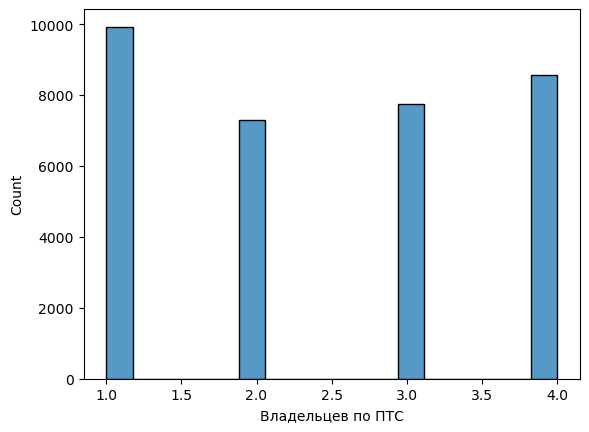

In [32]:
sns.histplot(df['Владельцев по ПТС']);

Этот признак, думаю, стоит заполнить по медианному значению в разрезе модели авто. Из-за специфики модели, её удачности исполнения и народной любви к ней количество владельцев может сильно варьироваться, учитывая что 4 подразумевает 4 и больше.

In [33]:
median_owners = df.groupby('Модель авто')['Владельцев по ПТС'].transform(
    'median')
df['Владельцев по ПТС'] = df['Владельцев по ПТС'].fillna(median_owners)
df['Владельцев по ПТС'].isna().sum()

73

Оставшихся заполним средним значением по признаку.

In [34]:
df['Владельцев по ПТС'] = df['Владельцев по ПТС'].fillna(
    np.mean(df['Владельцев по ПТС']))
df['Владельцев по ПТС'].isna().sum()

0

## Объём двигателя, л.

In [35]:
df['Объём двигателя, л'].isna().sum()

126

Заполним пропуски медианным значением по модификации авто.

In [36]:
median_engine_vol = df.groupby('Модификация')['Объём двигателя, л'].transform(
    'median')
df['Объём двигателя, л'] = df['Объём двигателя, л'].fillna(median_engine_vol)
df['Объём двигателя, л'].isna().sum()

60

Остальное также заполним средним значением.

In [37]:
df['Объём двигателя, л'] = df['Объём двигателя, л'].fillna(
    np.mean(df['Объём двигателя, л']))
df['Объём двигателя, л'].isna().sum()

0

## Комплектация.

In [38]:
df['Комплектация'].value_counts(dropna=False)[:20]

Комплектация
Базовая         10771
NaN              7278
Comfort          1135
Premium           683
Luxury            678
Prestige          636
Elite             592
Flagship          545
Tech              482
Active            441
Elegance          437
Luxe              424
Sport             376
Executive         372
Exclusive         340
SE                335
Style             334
HSE               250
Особая серия      212
Ultimate          203
Name: count, dtype: int64

Комплектацию мы заполним самым часто встречаемым значением в разрезе Бренда авто.

In [39]:
mode_equipment = df.groupby(
    'Бренд авто')['Комплектация'].transform(lambda x: x.mode()[0])
df['Комплектация'] = df['Комплектация'].fillna(mode_equipment)
df['Комплектация'].isna().sum()

0

## Тип кузова.

In [40]:
df['Тип кузова'].value_counts(dropna=False)

Тип кузова
Внедорожник 5-дверный    14764
Седан                    12126
Хетчбек 5-дверный         4104
Лифтбек                   1450
Фургон                    1391
Минивэн                   1298
Универсал                 1033
Хетчбек 3-дверный          371
Купе                       250
Пикап                      242
Микроавтобус               242
Внедорожник 3-дверный      130
NaN                        111
Кабриолет                   56
Name: count, dtype: int64

Тип кузова заполним по модели авто.

In [41]:
body_type = df.groupby('Модель авто')['Тип кузова'].transform(
    lambda x: x.mode()[0])
df['Тип кузова'] = df['Тип кузова'].fillna(body_type)
df['Тип кузова'].isna().sum()

0

## Управление климатом.

In [42]:
df['Управление климатом'].value_counts(dropna=False)

Управление климатом
NaN                            16679
Климат-контроль многозонный    10791
Кондиционер                     5279
Климат-контроль однозонный      3863
Управление на руле               738
Атермальное остекление           207
Кожа                               3
Цветной                            2
Тёмный                             2
Салон                              2
Шины и диски                       1
Противотуманные                    1
Name: count, dtype: int64

Достаточно много пропусков. Попробуем сначала заполнить самым частым значением в разрезе Модификации и Комплектации.

In [43]:
mode_climate = df.groupby(
    ['Модификация', 'Комплектация'])['Управление климатом'].transform(
        lambda x: x.mode()[0] if not x.isna().all() else np.NaN)
df['Управление климатом'] = df['Управление климатом'].fillna(mode_climate)
df['Управление климатом'].isna().sum()

1141

Попробуем дозаполнить, только теперь в разрезе модели авто.

In [44]:
mode_climate_model = df.groupby(
    ['Модель авто'])['Управление климатом'].transform(
        lambda x: x.mode()[0] if not x.isna().all() else np.NaN)
df['Управление климатом'] = df['Управление климатом'].fillna(
    mode_climate_model)
df['Управление климатом'].isna().sum()

75

Остальное заполним модой по брендам.

In [45]:
mode_climate_brand = df.groupby(
    ['Бренд авто'])['Управление климатом'].transform(
        lambda x: x.mode()[0] if not x.isna().all() else np.NaN)
df['Управление климатом'] = df['Управление климатом'].fillna(
    mode_climate_brand)
df['Управление климатом'].isna().sum()

0

Надо разобраться со странными значениями Кожа, Цветной, Тёмный, Противотуманные, Салон. Управление на руле оставим, пусть оно подразумевает наличие управления климатом, но с расположением на руле.                    

In [46]:
mode_list = list(df['Управление климатом'].value_counts().index[:5])
df.loc[~df['Управление климатом'].isin(mode_list),
       'Управление климатом'] = 'Климат-контроль многозонный'
df['Управление климатом'].value_counts(dropna=False)

Управление климатом
Климат-контроль многозонный    17854
Кондиционер                    12539
Климат-контроль однозонный      5982
Управление на руле               846
Атермальное остекление           347
Name: count, dtype: int64

## ПТС.

In [47]:
df['ПТС'].value_counts(dropna=False)

ПТС
Оригинал       18133
NaN            10572
Дубликат        5016
Электронный     3847
Name: count, dtype: int64

Тут также применим наш обычный подход, и заполним пропуски модой в разрезе модификации.

In [48]:
pts_mode = df.groupby('Модификация')['ПТС'].transform(
    lambda x: x.mode()[0] if not x.isna().all() else np.NaN)
df['ПТС'] = df['ПТС'].fillna(pts_mode)
df['ПТС'].isna().sum()

128

Оставшееся заполним модой по признаку.

In [49]:
df['ПТС'] = df['ПТС'].fillna(df['ПТС'].mode()[0])
df['ПТС'].isna().sum()

0

## Обмен.

In [50]:
df['Обмен'].value_counts(dropna=False)

Обмен
Не интересует    21468
Возможен          9285
NaN               6815
Name: count, dtype: int64

In [51]:
exchange_mode = df.groupby('Модификация')['Обмен'].transform(
    lambda x: x.mode()[0] if not x.isna().all() else np.NaN)
df['Обмен'] = df['Обмен'].fillna(exchange_mode)
df['Обмен'].isna().sum()

112

In [52]:
df['Обмен'] = df['Обмен'].fillna(df['Обмен'].mode()[0])
df['Обмен'].isna().sum()

0

Сразу же бинаризуем признак: 1 - Возможен, 0 - Не интересует.

In [53]:
df['Обмен'] = df['Обмен'].map(preproc['map_change_columns']['Обмен'])
df['Обмен'].value_counts()

Обмен
0    26315
1    11253
Name: count, dtype: int64

## Город и Федеральный округ.

In [54]:
df[df['Город'].isna()
   | df['Федеральный округ'].isna()].shape[0] / df.shape[0] * 100

3.729237649063032

In [55]:
df[df['Город'].isna() | df['Федеральный округ'].isna()][:5]

,Название авто,Рейтинг,Цена,Расположение,Год выпуска,Поколение,"Пробег, км","История пробега, кол-во записей",Владельцев по ПТС,Состояние,Модификация,"Объём двигателя, л",Тип двигателя,Коробка передач,Привод,Комплектация,Тип кузова,Цвет,Руль,Управление климатом,ПТС,Обмен,Бренд авто,Модель авто,Город,Федеральный округ,Наименование поколения,"Выпуск, кол-во лет","Мощность двигателя, лс"
20,"Audi Q8 3.0 AT, 2019, 101 000 км",5.0,6967000,"Московская обл., Одинцовский г.о., рп. Заречье...",2019,I (2018—2023),101000.0,9.0,1.0,Не битый,45 TDI 3.0 quattro Tiptronic,3.0,Дизель,Автомат,Полный,Базовая,Внедорожник 5-дверный,Чёрный,Левый,Климат-контроль многозонный,Оригинал,1,Audi,Q8,NaN,NaN,I,5.0,249.0
58,"Audi RS Q8 4.0 AT, 2020, 54 900 км",5.0,11800000,"Минск, пр-т Независимости",2020,I (2019—2024),54900.0,0.0,1.0,Не битый,4.0 TFSI quattro Tiptronic,4.0,Бензин,Автомат,Полный,Quattro,Внедорожник 5-дверный,Чёрный,Левый,Климат-контроль многозонный,Оригинал,0,Audi,RS Q8,NaN,NaN,I,5.0,600.0
65,"Audi A4 1.8 CVT, 2014, 137 000 км",4.8,1650000,"Мелитопольский р-н, Мелитопольская городская о...",2014,B8 рестайлинг (2011—2015),137000.0,10.0,1.0,Не битый,1.8 TFSI Multitronic,1.8,Бензин,Вариатор,Передний,Базовая,Седан,Белый,Левый,Климат-контроль однозонный,Оригинал,0,Audi,A4,NaN,NaN,B8 рестайлинг,4.0,170.0
71,"Audi Q8 3.0 AT, 2019, 84 900 км",5.0,6690000,"Минск, Интернациональная ул., 17",2019,I (2018—2023),84900.0,6.0,1.0,Не битый,45 TDI 3.0 quattro Tiptronic,3.0,Дизель,Автомат,Полный,Sport,Внедорожник 5-дверный,Серый,Левый,Климат-контроль многозонный,Оригинал,0,Audi,Q8,NaN,NaN,I,5.0,249.0
74,"Audi A5 3.0 AT, 2018, 200 000 км",5.0,3800000,Минск,2018,II (2016—2020),200000.0,0.0,1.0,Не битый,45 TDI 3.0 quattro Tiptronic,3.0,Дизель,Автомат,Полный,Базовая,Лифтбек,Красный,Левый,Климат-контроль многозонный,Оригинал,0,Audi,A5,NaN,NaN,II,4.0,231.0


Пропущенными оказались города и округи, которые не распарсились. Их около 3.6 процентов, так что попробуем заполнить их модами по признакам.

In [56]:
df['Город'] = df['Город'].fillna(df['Город'].mode()[0])
df['Федеральный округ'] = df['Федеральный округ'].fillna(
    df['Федеральный округ'].mode()[0])
df[['Город', 'Федеральный округ']].isna().sum()

Город                0
Федеральный округ    0
dtype: int64

## Наименование поколения, Выпуск, кол-во лет и Мощность двигателя, лс.

Так как оставшихся пропусков немного, певые два признака заполним в ручную, а последний средним значением по признаку.

In [57]:
df[df['Наименование поколения'].isna() | df['Выпуск, кол-во лет'].isna()]

,Название авто,Рейтинг,Цена,Расположение,Год выпуска,Поколение,"Пробег, км","История пробега, кол-во записей",Владельцев по ПТС,Состояние,Модификация,"Объём двигателя, л",Тип двигателя,Коробка передач,Привод,Комплектация,Тип кузова,Цвет,Руль,Управление климатом,ПТС,Обмен,Бренд авто,Модель авто,Город,Федеральный округ,Наименование поколения,"Выпуск, кол-во лет","Мощность двигателя, лс"
36203,"ГАЗ ГАЗель NN 2.8 MT, 2022, 24 773 км",4.0,3499000,"Республика Башкортостан, Уфимский р-н, Михайло...",2022,I (2021–2024),24773.0,4.0,1.0,Не битый,2.8 D MT,2.8,Дизель,Механика,Задний,Базовая,Фургон,Синий,Левый,Кондиционер,Оригинал,0,ГАЗ,ГАЗель NN,Михайлов,Центральный,NaN,NaN,149.0


In [58]:
df.at[36203, 'Наименование поколения'] = 'I'
df.at[36203, 'Выпуск, кол-во лет'] = 3

In [59]:
df[df['Наименование поколения'].isna() | df['Выпуск, кол-во лет'].isna()]

,Название авто,Рейтинг,Цена,Расположение,Год выпуска,Поколение,"Пробег, км","История пробега, кол-во записей",Владельцев по ПТС,Состояние,Модификация,"Объём двигателя, л",Тип двигателя,Коробка передач,Привод,Комплектация,Тип кузова,Цвет,Руль,Управление климатом,ПТС,Обмен,Бренд авто,Модель авто,Город,Федеральный округ,Наименование поколения,"Выпуск, кол-во лет","Мощность двигателя, лс"


In [60]:
df['Мощность двигателя, лс'] = df['Мощность двигателя, лс'].fillna(
    np.mean(df['Мощность двигателя, лс']))

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37568 entries, 0 to 37567
Data columns (total 29 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Название авто                    37568 non-null  object 
 1   Рейтинг                          37568 non-null  float64
 2   Цена                             37568 non-null  int64  
 3   Расположение                     37568 non-null  object 
 4   Год выпуска                      37568 non-null  int32  
 5   Поколение                        37568 non-null  object 
 6   Пробег, км                       37568 non-null  float64
 7   История пробега, кол-во записей  37568 non-null  float64
 8   Владельцев по ПТС                37568 non-null  float64
 9   Состояние                        37568 non-null  object 
 10  Модификация                      37568 non-null  object 
 11  Объём двигателя, л               37568 non-null  float64
 12  Тип двигателя     

## Генерация дополнительных признаков.

Сразу сформируем признак по ПТС - Много владельцев. 4 будет подразумевать 4 и более - значение будет 1, остальные - значение 0.

In [62]:
df['Много владельцев'] = np.where(df['Владельцев по ПТС'] == 4, 1, 0)
df['Много владельцев'].value_counts()

Много владельцев
0    29011
1     8557
Name: count, dtype: int64

Также думаю будет полезен признак - Срок эксплуатации.

In [63]:
curr_year = datetime.now().year
df['Срок эксплуатации'] = curr_year - df['Год выпуска']
df['Срок эксплуатации'][:5]

0    11
1     3
2     2
3    11
4     2
Name: Срок эксплуатации, dtype: int32

Ещё попробуем добавить Степень износа автомобиля по пробегу авто - категориальный признак, будут бины до 60 тысяч - малая, 60-100 тысяч - умеренная, 100-180 тысяч - средняя, 180 + большая.

In [64]:
preproc['map_bins']['Пробег_км']

{'bins': [0, 60000, 100000, 180000, 1500000],
 'labels': ['Маленькая', 'Умеренная', 'Средняя', 'Большая']}

In [65]:
df['Степень износа'] = pd.cut(
    df['Пробег_км'],
    bins=preproc['map_bins']['Пробег_км']['bins'],
    labels=preproc['map_bins']['Пробег_км']['labels'])
df['Степень износа'].value_counts()

Степень износа
Большая      13546
Средняя      10655
Маленькая     9164
Умеренная     4203
Name: count, dtype: int64

Удалим теперь уже ненужные признаки.

In [66]:
df['Поколение'] = df['Наименование поколения']
df = df.drop(preproc['drop_columns'], axis=1)

In [67]:
df[:5]

,Рейтинг,Цена,Год выпуска,Поколение,"Пробег, км","История пробега, кол-во записей",Владельцев по ПТС,Состояние,Модификация,"Объём двигателя, л",Тип двигателя,Коробка передач,Привод,Комплектация,Тип кузова,Цвет,Руль,Управление климатом,ПТС,Обмен,Бренд авто,Модель авто,Город,Федеральный округ,"Выпуск, кол-во лет","Мощность двигателя, лс",Много владельцев,Срок эксплуатации,Степень износа
0,4.8,1745000,2013,I,166000.0,11.0,3.0,Не битый,2.0 TFSI quattro S tronic,2.0,Бензин,Робот,Полный,Базовая,Внедорожник 5-дверный,Чёрный,Левый,Климат-контроль многозонный,Оригинал,0,Audi,Q3,Самара,Приволжский,3.0,170.0,0,11,Средняя
1,5.0,8785500,2021,4M рестайлинг,29226.0,2.0,1.0,Не битый,45 TDI 3.0 quattro Tiptronic,3.0,Дизель,Автомат,Полный,Sport,Внедорожник 5-дверный,Чёрный,Левый,Климат-контроль многозонный,Оригинал,0,Audi,Q7,Волоколамск,Центральный,5.0,249.0,0,3,Маленькая
2,5.0,11200000,2022,I,100.0,3.0,1.0,Не битый,55 TFSI 3.0 quattro Tiptronic,3.0,Бензин,Автомат,Полный,Advance,Внедорожник 5-дверный,Чёрный,Левый,Климат-контроль многозонный,Электронный,0,Audi,Q8,Москва,Центральный,5.0,340.0,0,2,Маленькая
3,4.8,2099000,2013,4L рестайлинг,151488.0,15.0,2.0,Не битый,3.0 TDI quattro Tiptronic,3.0,Дизель,Автомат,Полный,Базовая,Внедорожник 5-дверный,Белый,Левый,Климат-контроль многозонный,Оригинал,1,Audi,Q7,Жуков,Центральный,6.0,245.0,0,11,Средняя
4,5.0,10400000,2022,I,3261.0,2.0,1.0,Не битый,50 TDI 3.0 quattro Tiptronic,3.0,Дизель,Автомат,Полный,Базовая,Внедорожник 5-дверный,Красный,Левый,Климат-контроль многозонный,Электронный,0,Audi,Q8,Москва,Центральный,5.0,286.0,0,2,Маленькая


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37568 entries, 0 to 37567
Data columns (total 29 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   Рейтинг                          37568 non-null  float64 
 1   Цена                             37568 non-null  int64   
 2   Год выпуска                      37568 non-null  int32   
 3   Поколение                        37568 non-null  object  
 4   Пробег, км                       37568 non-null  float64 
 5   История пробега, кол-во записей  37568 non-null  float64 
 6   Владельцев по ПТС                37568 non-null  float64 
 7   Состояние                        37568 non-null  object  
 8   Модификация                      37568 non-null  object  
 9   Объём двигателя, л               37568 non-null  float64 
 10  Тип двигателя                    37568 non-null  object  
 11  Коробка передач                  37568 non-null  object  
 12  Прив

## Цена - целевая пременная.

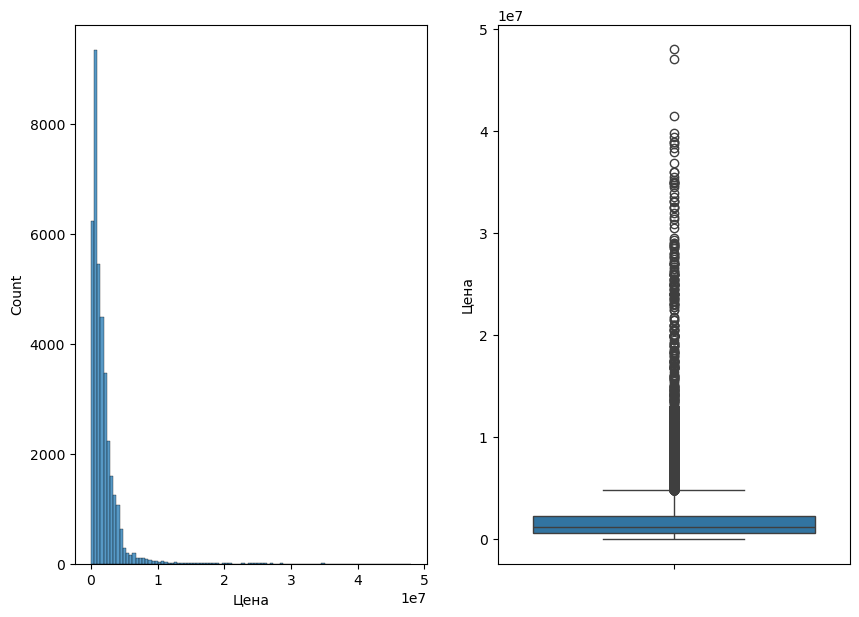

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(10,7))
    
sns.histplot(df['Цена'], bins=100, ax=axes[0]);
sns.boxplot(df['Цена'], ax=axes[1]);

Так как целевая переменная распределена не нормально, очень похоже на геометрическое распределение, при обучении линейных моделей будем её логарифмировать. Дополнительно избавимся от выбросов, но не будем учитывать нижнюю границу, т. к. цена не может быть меньше 0. Также удалим возможные нежелательные символы в именах колонок перед сохранением датафрейма.

In [70]:
df = df.rename(columns=lambda x: re.sub('[^A-Za-zА-яа-я0-9_-ё]+', '_', x))

In [71]:
Q1 = np.quantile(df['Цена'], .25)
Q3 = np.quantile(df['Цена'], .75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df_filtered = df[df['Цена'] <= upper].reset_index().drop('index', axis=1)

In [72]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35701 entries, 0 to 35700
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   Рейтинг                         35701 non-null  float64 
 1   Цена                            35701 non-null  int64   
 2   Год_выпуска                     35701 non-null  int32   
 3   Поколение                       35701 non-null  object  
 4   Пробег_км                       35701 non-null  float64 
 5   История_пробега_кол_во_записей  35701 non-null  float64 
 6   Владельцев_по_ПТС               35701 non-null  float64 
 7   Состояние                       35701 non-null  object  
 8   Модификация                     35701 non-null  object  
 9   Объём_двигателя_л               35701 non-null  float64 
 10  Тип_двигателя                   35701 non-null  object  
 11  Коробка_передач                 35701 non-null  object  
 12  Привод            

# Training.

## Baseline.

Немного оптимизируем датасет относительно памяти. 

In [73]:
df_filtered = df_filtered.astype(preproc['change_type_columns'],
                                 errors='raise')
df_filtered[df.select_dtypes('object').columns] = df_filtered[df.select_dtypes(
    'object').columns].astype('category')

In [74]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35701 entries, 0 to 35700
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   Рейтинг                         35701 non-null  float32 
 1   Цена                            35701 non-null  int32   
 2   Год_выпуска                     35701 non-null  int16   
 3   Поколение                       35701 non-null  category
 4   Пробег_км                       35701 non-null  int32   
 5   История_пробега_кол_во_записей  35701 non-null  int8    
 6   Владельцев_по_ПТС               35701 non-null  int8    
 7   Состояние                       35701 non-null  category
 8   Модификация                     35701 non-null  category
 9   Объём_двигателя_л               35701 non-null  float32 
 10  Тип_двигателя                   35701 non-null  category
 11  Коробка_передач                 35701 non-null  category
 12  Привод            

Мы оптимизировали расход памяти на 75%. Отлично! Теперь получим наши тренировочные и тестовые выборки. А также валидационный сет для последующего обучения модели.

In [75]:
df_train, df_test = split_data.split_dataset_holdout(dataset=df_filtered,
                                                     **preproc)
X_train, X_test, y_train, y_test = split_data.get_train_test(
    df_train, df_test, target=train['target_column'])
X_train_, X_val, y_train_, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=train['random_state'])

In [76]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((30345, 28), (5356, 28), (30345,), (5356,))

Обучим бейзлайн модели LGBMRegressor.

In [77]:
baseline = LGBMRegressor(verbose=-1, random_state=train['random_state'])
baseline.fit(X_train, y_train)

LGBMRegressor(random_state=1618, verbose=-1)

In [78]:
y_pred_baseline = baseline.predict(X_test)
metrics_df = pd.DataFrame()
metrics_df = metrics.concat_metrics(metrics_df,
                                    y_train,
                                    baseline.predict(X_train),
                                    X_train,
                                    model_name='LGBM_baseline_train')
metrics_df = metrics.concat_metrics(metrics_df,
                                    y_test,
                                    y_pred_baseline,
                                    X_test,
                                    model_name='LGBM_baseline_test')
metrics_df

,Модель,MAE,R2_Adjusted,WAPE,Huber_Loss,RMSE
0,LGBM_baseline_train,143841.474995,0.960794,9.801695,193465.879356,215486.924679
0,LGBM_baseline_test,168153.617468,0.947596,11.486667,226165.710982,247068.896994


In [79]:
metrics.check_overfitting(X_train, y_train, X_test, y_test, baseline)

{'Имя модели': {'LGBMRegressor'},
 'MAE train': {143841.47499530856},
 'MAE test': {168153.61746776526},
 'MAE diff, %': {14.46}}

Учитывая, что даже линейные модели в бейзлайне показывают разницу MAE около 20%, то LGBM даже не переобучился.

## Tuning.

In [80]:
for num in tqdm_notebook([100, 300, 600, 1000, 1300, 1500, 2000, 5000]):
    lgbm = LGBMRegressor(n_estimators=num, verbose=-1, random_state=train['random_state'])
    lgbm.fit(X_train, y_train)
    metrics_df = metrics.concat_metrics(metrics_df, y_test,
                                        lgbm.predict(X_test), X_test,
                                        f'LGBM_{num}_estimators')

  0%|          | 0/8 [00:00<?, ?it/s]

In [81]:
metrics_df.sort_values(by='MAE', ascending=True)

,Модель,MAE,R2_Adjusted,WAPE,Huber_Loss,RMSE
0,LGBM_baseline_train,143841.474995,0.960794,9.801695,193465.879356,215486.924679
0,LGBM_1300_estimators,159641.298780,0.950774,10.905186,214716.642347,239459.068587
0,LGBM_1000_estimators,159754.336406,0.950917,10.912908,214868.677954,239112.743726
0,LGBM_1500_estimators,159797.276721,0.950655,10.915841,214926.432677,239748.611238
0,LGBM_2000_estimators,160269.030548,0.950132,10.948067,215560.941575,241017.487173
0,LGBM_600_estimators,160292.503651,0.950995,10.949670,215592.512899,238920.658434
0,LGBM_5000_estimators,161764.404225,0.948957,11.050216,217572.219171,243839.016188
0,LGBM_300_estimators,161973.511650,0.950431,11.064501,217853.468657,240292.075790
0,LGBM_baseline_test,168153.617468,0.947596,11.486667,226165.710982,247068.896994
0,LGBM_100_estimators,168153.617468,0.947596,11.486667,226165.710982,247068.896994


In [82]:
def objective(trial,
              X: pd.DataFrame,
              y: pd.Series,
              n_folds: int = 5,
              random_state: int = 1618) -> np.array:
    '''
    Функция для подбора гиперпараметров через фреймворк Optuna для LGBMRegressor.
    :param trial: количество испытаний.
    :param X: матрица объект-признаков.
    :param y: целевая переменная.
    :param n_folds: количество фолдов.
    :param random_state: фиксирование случайности.
    :return: среднее значение MAE по фолдам.
    '''
    params = {
        'n_estimators':
        trial.suggest_categorical('n_estimators', [1300]),
        'learning_rate':
        trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'max_depth':
        trial.suggest_int('max_depth', 3, 13),
        'num_leaves':
        trial.suggest_int('num_leaves', 2, 2**13),
        'lambda_l1':
        trial.suggest_float('lambda_l1', 0, 100),
        'lambda_l2':
        trial.suggest_float('lambda_l2', 0, 100),
        'feature_fraction':
        trial.suggest_float('feature_fraction', 0.4, 1),
        'bagging_freq':
        trial.suggest_int('bagging_freq', 1, 15),
        'bagging_fraction':
        trial.suggest_float('bagging_fraction', 0.05, 1),
        'min_split_gain':
        trial.suggest_int('min_split_gain', 0, 20),
        'extra_trees':
        trial.suggest_categorical('extra_trees', [True]),
        'extra_seed':
        trial.suggest_categorical('extra_seed', [random_state]),
        'colsample_bytree':
        trial.suggest_float('colsample_bytree', 0.5, 1),
        'verbose':
        trial.suggest_categorical('verbose', [-1]),
        'early_stopping_rounds':
        trial.suggest_categorical('early_stopping_rounds', [50]),
        'random_state':
        trial.suggest_categorical('random_state', [random_state]),
    }

    cv_opt = StratifiedKFold(n_splits=n_folds,
                             shuffle=True,
                             random_state=random_state)
    cv_predicts = np.empty(n_folds)

    for idx, (train_idx, test_idx) in enumerate(cv_opt.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        pruning_callback = optuna.integration.LightGBMPruningCallback(
            trial, metric='l1')

        model = LGBMRegressor(**params)
        model.fit(X_train,
                  y_train,
                  eval_set=[(X_val, y_val)],
                  eval_metric='mae',
                  callbacks=[pruning_callback])

        y_pred = model.predict(X_val)

        cv_predicts[idx] = mean_absolute_error(y_val, y_pred)

    return np.mean(cv_predicts)

In [83]:
sampler = optuna.samplers.TPESampler(seed=train['random_state'])
pruner = optuna.pruners.MedianPruner(n_warmup_steps=10)
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize',
                            sampler=sampler,
                            pruner=pruner,
                            study_name='LGBM')
function = lambda trial: objective(trial,
                                   X_train,
                                   y_train,
                                   n_folds=train['n_folds'],
                                   random_state=train['random_state'])
study.optimize(function,
               n_trials=train['n_trials'] * 4,
               show_progress_bar=True,
               n_jobs=-1)

  0%|          | 0/160 [00:00<?, ?it/s]

In [84]:
study.best_value

165881.71781504355

In [85]:
study.best_params

{'n_estimators': 1300,
 'learning_rate': 0.07685090980117151,
 'max_depth': 9,
 'num_leaves': 3367,
 'lambda_l1': 62.7731772964803,
 'lambda_l2': 9.853439584191229,
 'feature_fraction': 0.8491502650947874,
 'bagging_freq': 7,
 'bagging_fraction': 0.9835283186724788,
 'min_split_gain': 16,
 'extra_trees': True,
 'extra_seed': 1618,
 'colsample_bytree': 0.6663484682464349,
 'verbose': -1,
 'early_stopping_rounds': 50,
 'random_state': 1618}

In [86]:
plot_optimization_history(study);

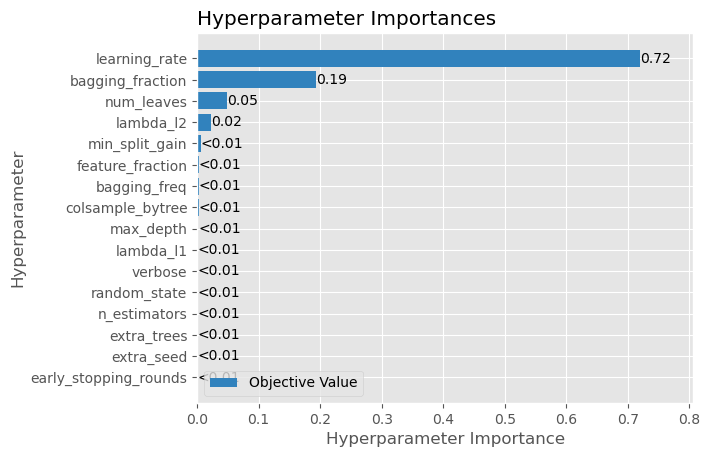

In [87]:
plot_param_importances(study);

## Train with best params.

In [88]:
tuned_lgbm = LGBMRegressor(**study.best_params)
tuned_lgbm.fit(X_train_,
               y_train_,
               eval_set=[(X_val, y_val)],
               eval_metric='mae')
y_pred_tuned = tuned_lgbm.predict(X_test)

In [89]:
metrics_df = metrics.concat_metrics(metrics_df,
                                    y_train,
                                    tuned_lgbm.predict(X_train),
                                    X_train,
                                    model_name='LGBM_tuned_train')
metrics_df = metrics.concat_metrics(metrics_df,
                                    y_test,
                                    y_pred_tuned,
                                    X_test,
                                    model_name='LGBM_tuned_test')

In [90]:
metrics_df

,Модель,MAE,R2_Adjusted,WAPE,Huber_Loss,RMSE
0,LGBM_baseline_train,143841.474995,0.960794,9.801695,193465.879356,215486.924679
0,LGBM_baseline_test,168153.617468,0.947596,11.486667,226165.710982,247068.896994
0,LGBM_100_estimators,168153.617468,0.947596,11.486667,226165.710982,247068.896994
0,LGBM_300_estimators,161973.511650,0.950431,11.064501,217853.468657,240292.075790
0,LGBM_600_estimators,160292.503651,0.950995,10.949670,215592.512899,238920.658434
0,LGBM_1000_estimators,159754.336406,0.950917,10.912908,214868.677954,239112.743726
0,LGBM_1300_estimators,159641.298780,0.950774,10.905186,214716.642347,239459.068587
0,LGBM_1500_estimators,159797.276721,0.950655,10.915841,214926.432677,239748.611238
0,LGBM_2000_estimators,160269.030548,0.950132,10.948067,215560.941575,241017.487173
0,LGBM_5000_estimators,161764.404225,0.948957,11.050216,217572.219171,243839.016188


In [91]:
metrics.check_overfitting(X_train, y_train, X_test, y_test, tuned_lgbm)

{'Имя модели': {'LGBMRegressor'},
 'MAE train': {124974.85391525316},
 'MAE test': {160959.35865927982},
 'MAE diff, %': {22.36}}

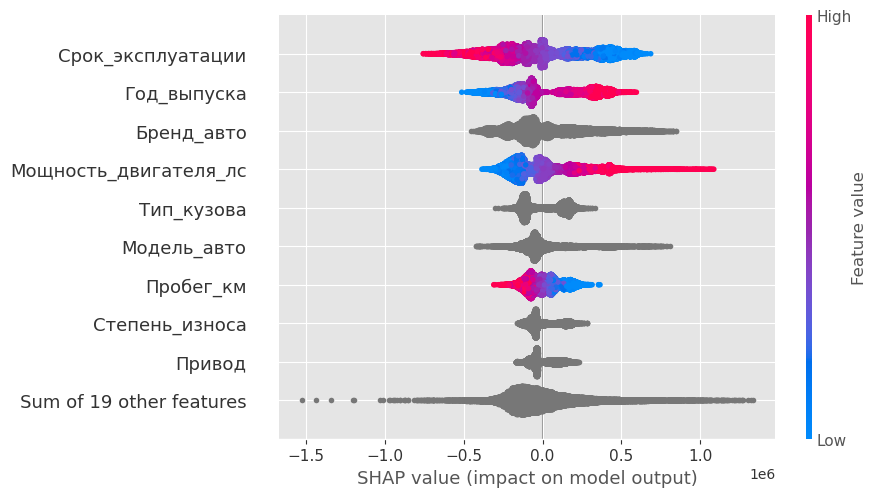

In [92]:
explainer = shap.TreeExplainer(tuned_lgbm)
explanation = explainer(X_train)
shap.plots.beeswarm(explanation)

Как видим, наиболее важными признаками, влияющими на цену, оказались год выпуска, и, как следствие, срок эксплуатации, а также взаимосвязанные переменные мощность двигателя, и его объём. Не остался в стороне и признак Пробег - логично, что чем больше пробег, тем выше износ и тем меньше цена.

In [2]:
df = pd.read_csv('../data/processed/train.csv')

In [3]:
df

,Рейтинг,Цена,Год_выпуска,Пробег_км,История_пробега_кол_во_записей,Владельцев_по_ПТС,Объём_двигателя_л,Выпуск_кол_во_лет,Мощность_двигателя_лс,Поколение,Состояние,Модификация,Тип_двигателя,Коробка_передач,Привод,Комплектация,Тип_кузова,Цвет,Руль,Управление_климатом,ПТС,Обмен,Бренд_авто,Модель_авто,Город,Федеральный_округ,Много_владельцев,Срок_эксплуатации,Степень_износа
0,4.6,700000,2013,20800,19,4,2.0,5,135,I,Не битый,2.0 4WD MT,Бензин,Механика,Полный,Базовая,Внедорожник 5-дверный,Серебряный,Левый,Климат-контроль многозонный,Оригинал,0,Renault,Duster,Нижневартовск,Уральский,1,11,Маленькая
1,4.9,1300000,2014,400000,18,2,2.0,3,148,XV50,Не битый,2.0 AT,Бензин,Автомат,Передний,Standard,Седан,Белый,Левый,Управление на руле,Оригинал,0,Toyota,Camry,Москва,Центральный,0,10,Большая
2,4.7,749900,2008,165000,7,2,1.6,4,122,ED,Не битый,1.6 MT,Бензин,Механика,Передний,Comfort,Универсал,Чёрный,Левый,Климат-контроль однозонный,Оригинал,0,Kia,Ceed,Екатеринбург,Уральский,0,16,Средняя
3,4.8,610000,2011,286000,20,3,1.4,4,160,Mk6,Не битый,1.4 TSI MT,Бензин,Механика,Передний,Базовая,Хетчбек 5-дверный,Белый,Левый,Управление на руле,Дубликат,1,Volkswagen,Golf,Дмитров,Центральный,0,13,Большая
4,4.8,5000000,2014,245000,32,4,4.5,3,235,200 рестайлинг,Не битый,4.5 D AT,Дизель,Автомат,Полный,Базовая,Внедорожник 5-дверный,Белый,Левый,Климат-контроль многозонный,Оригинал,0,Toyota,Land Cruiser,Екатеринбург,Уральский,1,10,Большая
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31542,4.4,950000,2007,856057,11,1,2.3,3,238,I,Не битый,2.3 4WD AT,Бензин,Автомат,Полный,Базовая,Внедорожник 5-дверный,Бордовый,Левый,Климат-контроль многозонный,Оригинал,1,Mazda,CX-7,Махачкала,Северо-Кавказский,0,17,Большая
31543,4.7,2200000,2019,69000,0,1,2.4,6,149,I,Не битый,2.4 AT,Бензин,Автомат,Передний,Базовая,Внедорожник 5-дверный,Бежевый,Левый,Климат-контроль многозонный,Оригинал,0,Geely,Atlas,Москва,Центральный,0,5,Умеренная
31544,4.8,415000,2008,198000,17,4,1.5,13,102,II,Не битый,1.5 MT,Бензин,Механика,Передний,Lux,Седан,Чёрный,Левый,Кондиционер,Оригинал,0,Hyundai,Accent,Комсомольск,Центральный,1,16,Большая
31545,4.6,5150000,2023,1216,0,1,2.0,1,249,I,Не битый,2.0 T-GDI 4WD DCT,Бензин,Робот,Полный,Prestige,Внедорожник 5-дверный,Белый,Левый,Климат-контроль многозонный,Электронный,1,EXEED,RX,Набережные Челны,Приволжский,0,1,Маленькая


In [148]:
df['Модификация'].nunique()

1045

In [25]:
modif_dict = df.groupby('Модификация')['Рейтинг'].mean().round(2).to_dict()
modif_dict

{'0.0 4WD AT': 4.92,
 '0.0 AMT': 4.0,
 '0.0 AT': 4.68,
 '0.6 eDrive AT': 5.0,
 '0.7 4WD AT': 4.47,
 '0.7 4WD CVT': 4.99,
 '0.7 AT': 4.78,
 '0.7 CVT': 4.97,
 '0.8 AT': 4.7,
 '0.8 MT': 4.66,
 '1.0 AMT': 4.84,
 '1.0 AT': 4.72,
 '1.0 CVT': 4.69,
 '1.0 MT': 4.73,
 '1.1 AT': 4.74,
 '1.1 MT': 4.51,
 '1.2 AMT': 4.45,
 '1.2 AT': 4.83,
 '1.2 CVT': 4.82,
 '1.2 DIG-T CVT': 4.69,
 '1.2 DIG-T MT': 4.67,
 '1.2 Hybrid AT': 5.0,
 '1.2 MPI MT': 4.8,
 '1.2 MT': 4.66,
 '1.2 PureTech AT': 5.0,
 '1.2 TFSI S tronic': 4.76,
 '1.2 TSI DSG': 4.82,
 '1.2 TSI MT': 4.83,
 '1.2hyb AT': 4.9,
 '1.3 4WD AT': 4.93,
 '1.3 AMT': 4.6,
 '1.3 AT': 4.66,
 '1.3 CDTI MT': 4.6,
 '1.3 CDTi MT': 4.55,
 '1.3 CVT': 4.86,
 '1.3 Hybrid CVT': 4.8,
 '1.3 MT': 4.62,
 '1.3 TCe 4WD CVT': 4.6,
 '1.3 TCe 4WD MT': 4.6,
 '1.3 TCe CVT': 4.6,
 '1.3 i-VTEC AMT': 4.6,
 '1.3hyb CVT': 4.7,
 '1.4 AMT': 4.76,
 '1.4 AT': 4.69,
 '1.4 D AT': 4.67,
 '1.4 D MT': 4.68,
 '1.4 D-4D MT': 4.7,
 '1.4 DSG': 4.75,
 '1.4 HDi MT': 4.65,
 '1.4 Hybrid CVT': 4.9,
 '1.

In [155]:
test_df['0.0 4WD AT']

4.92

In [56]:
test_brand = df.groupby([
    'Бренд_авто', 'Модель_авто', 'Модификация', 'Поколение'
])['Рейтинг'].agg('mean').round(2).reset_index(name='Рейтинг')

In [57]:
test_brand

,Бренд_авто,Модель_авто,Модификация,Поколение,Рейтинг
0,Audi,100,1.8 MT,C3,4.70
1,Audi,100,1.8 MT,C3 рестайлинг,5.00
2,Audi,100,1.8 quattro MT,C3,4.70
3,Audi,100,2.0 MT,C3 рестайлинг,5.00
4,Audi,100,2.0 MT,C4,4.80
...,...,...,...,...,...
4537,ГАЗ,Соболь 2752,2.8 D MT,II,4.30
4538,ГАЗ,Соболь 2752,2.9 4WD MT,II,4.30
4539,ГАЗ,Соболь 2752,2.9 MT,II,4.42
4540,ГАЗ,Соболь NN,2.7 MT,I,5.00


In [58]:
brand_dict = {
    key: test_brand[test_brand['Бренд_авто'] == key]
    ['Модель_авто'].unique().tolist()
    for key in test_brand['Бренд_авто'].unique()
}
brand_dict

{'Audi': ['100',
  '200',
  '80',
  '90',
  'A1',
  'A2',
  'A3',
  'A4',
  'A4 Allroad Quattro',
  'A5',
  'A6',
  'A6 Allroad Quattro',
  'A7',
  'A8',
  'Coupe',
  'Q3',
  'Q4 e-tron',
  'Q5',
  'Q5 Sportback',
  'Q6',
  'Q7',
  'Q8',
  'RS Q8',
  'RS6',
  'RS7',
  'S3',
  'S4',
  'S5',
  'S6',
  'S7',
  'S8',
  'SQ5',
  'SQ5 Sportback',
  'TT',
  'e-tron'],
 'BMW': ['1 серия',
  '2 серия',
  '2 серия Gran Coupe',
  '2 серия Gran Tourer',
  '3 серия',
  '3 серия GT',
  '4 серия',
  '4 серия Gran Coupe',
  '5 серия',
  '5 серия GT',
  '6 серия',
  '6 серия GT',
  '7 серия',
  '8 серия',
  '8 серия Gran Coupe',
  'M3',
  'M4',
  'M5',
  'M6',
  'M8',
  'M8 серия Gran Coupe',
  'X1',
  'X2',
  'X3',
  'X4',
  'X5',
  'X5 M',
  'X6',
  'X6 M',
  'X7',
  'XM',
  'Z4',
  'i3'],
 'Changan': ['Alsvin',
  'Auchan X5',
  'Benben E-Star AMT',
  'CS35',
  'CS35 Plus',
  'CS55 Plus',
  'CS75',
  'CS75 Plus',
  'CS85',
  'CS95',
  'CS95 Plus',
  'Eado',
  'Eado Plus',
  'Hunter',
  'Hunter Plus',

In [59]:
model_dict = {
    key: test_brand[test_brand['Модель_авто'] == key]
    ['Модификация'].unique().tolist()
    for key in test_brand['Модель_авто'].unique()
}
model_dict

{'100': ['1.8 MT',
  '1.8 quattro MT',
  '2.0 MT',
  '2.2 MT',
  '2.3 AT',
  '2.3 MT',
  '2.5 D AT',
  '2.6 MT',
  '2.8 AT',
  '2.8 MT',
  '2.8 quattro MT'],
 '200': ['2.2 quattro MT'],
 '80': ['1.6 D MT', '1.6 MT', '1.8 MT', '2.0 AT', '2.0 MT', '2.6 MT'],
 '90': ['2.0 MT'],
 'A1': ['1.4 TFSI S tronic'],
 'A2': ['1.4 MT'],
 'A3': ['1.2 TFSI S tronic',
  '1.4 TFSI S tronic',
  '1.6 MT',
  '1.6 S tronic',
  '1.6 Tiptronic',
  '1.8 AT',
  '1.8 MT',
  '1.8 TFSI S Tronic',
  '1.8 TFSI S tronic',
  '1.8 TFSI quattro S tronic',
  '2.0 FSI Tiptronic',
  '30 TFSI 1.4 S tronic',
  '35 TFSI 1.4 S tronic',
  '35 TFSI 1.4 Tiptronic',
  '35 TFSI 1.5 S tronic',
  '40 TFSI 2.0 quattro S tronic'],
 'A4': ['1.6 AT',
  '1.6 MT',
  '1.8 AT',
  '1.8 MT',
  '1.8 TFSI MT',
  '1.8 TFSI Multitronic',
  '1.8 quattro MT',
  '1.8 quattro Tiptronic',
  '2.0 MT',
  '2.0 Multitronic',
  '2.0 TDI Multitronic',
  '2.0 TFSI Multitronic',
  '2.0 TFSI quattro S tronic',
  '2.0 TFSI quattro Tiptronic',
  '2.4 AT',
  '2.4 

In [75]:
gen_dict = {
    key: test_brand[test_brand['Модификация'] == key]
    ['Поколение'].unique().tolist()
    for key in test_brand['Модификация'].unique().tolist()
}
gen_dict

{'1.8 MT': ['C3',
  'C3 рестайлинг',
  'B3',
  '8L',
  '8L рестайлинг',
  'B5',
  'B5 рестайлинг',
  'B6',
  'C4',
  'C5',
  'C5 рестайлинг',
  '8N',
  'T11',
  'T11 рестайлинг',
  'I',
  'I рестайлинг',
  'II',
  'II рестайлинг',
  'III',
  'III рестайлинг',
  'I рестайлинг 2',
  'IX',
  'IX рестайлинг',
  'VIII',
  'VIII рестайлинг',
  'BA',
  'GG',
  'GG рестайлинг',
  'GH',
  'GH рестайлинг',
  'GE',
  'GF',
  'VI',
  'VII',
  'X',
  'X рестайлинг',
  'N16',
  'N16 рестайлинг',
  'P11 рестайлинг',
  'P12',
  'C11',
  'G',
  'H',
  'H рестайлинг',
  'J',
  'J рестайлинг',
  'A',
  'B',
  'B рестайлинг',
  'C рестайлинг',
  'C',
  'T220',
  'T250',
  'T250 рестайлинг',
  'T270',
  'E130',
  'Mk2',
  'Mk3',
  'IV',
  'B4',
  'B7'],
 '1.8 quattro MT': ['C3', 'B5 рестайлинг', 'B7', 'C4', 'C5 рестайлинг', '8N'],
 '2.0 MT': ['C3 рестайлинг',
  'C4',
  'B3',
  'B4',
  'B2',
  'B6',
  'B14',
  'A21',
  'I рестайлинг',
  'T21',
  'T21 рестайлинг',
  'I',
  'II',
  'II рестайлинг',
  'III',
 

In [62]:
rating_dict = {
    key: test_brand[test_brand['Поколение'] == key]['Рейтинг'].values[0]
    for key in test_brand['Поколение'].unique().tolist()
}
rating_dict

{'C3': 4.7,
 'C3 рестайлинг': 5.0,
 'C4': 4.8,
 'B3': 4.6,
 'B2': 4.9,
 'B4': 4.8,
 '8X': 4.8,
 '8X рестайлинг': 4.8,
 '8Z': 4.7,
 '8P рестайлинг 2': 4.8,
 '8V': 4.7,
 '8L': 4.5,
 '8P рестайлинг': 4.8,
 '8L рестайлинг': 4.3,
 '8V рестайлинг': 5.0,
 '8Y': 4.62,
 'B5 рестайлинг': 4.9,
 'B5': 4.8,
 'B6': 4.9,
 'B8': 4.9,
 'B8 рестайлинг': 4.81,
 'B7': 4.9,
 'B9': 4.7,
 'B9 рестайлинг': 5.0,
 'I': 4.5,
 'I рестайлинг': 4.77,
 'II': 5.0,
 'II рестайлинг': 5.0,
 'C5': 4.8,
 'C5 рестайлинг': 4.7,
 'C7 рестайлинг': 5.0,
 'C6 рестайлинг': 4.8,
 'С6': 4.6,
 'C7': 4.9,
 'C8': 4.7,
 'C6': 4.3,
 'D2': 4.8,
 'D3': 4.9,
 'D4': 4.8,
 'D4 рестайлинг': 5.0,
 'D3 рестайлинг 2': 4.4,
 'D3 рестайлинг': 5.0,
 'D2 рестайлинг': 4.9,
 'D5': 4.8,
 'FY': 4.77,
 '4M': 5.0,
 '4L': 4.7,
 '4L рестайлинг': 4.8,
 '4M рестайлинг': 5.0,
 '4K': 4.88,
 '8N': 4.7,
 '8S': 5.0,
 '8J рестайлинг': 4.6,
 'E81/E82/E87/E88 рестайлинг': 4.8,
 'F20/F21': 4.6,
 'F20/F21 рестайлинг': 4.9,
 'F20/F21 рестайлинг 2': 4.9,
 'E81/E82/E87/E

In [63]:
cars_dict = {
    'Бренды': brand_dict,
    'Модели': model_dict,
    'Поколения': gen_dict,
    'Рейтинги': rating_dict
}

In [64]:
cars_dict['Бренды']['Audi'][0]

'100'

In [65]:
cars_dict['Модели'][cars_dict['Бренды']['Audi'][0]][0]

'1.8 MT'

In [66]:
cars_dict['Поколения'][cars_dict['Модели'][cars_dict['Бренды']['Audi'][0]][0]][0]

['C3',
 'C3 рестайлинг',
 'B3',
 '8L',
 '8L рестайлинг',
 'B5',
 'B5 рестайлинг',
 'B6',
 'C4',
 'C5',
 'C5 рестайлинг',
 '8N',
 'T11',
 'T11 рестайлинг',
 'I',
 'I рестайлинг',
 'II',
 'II рестайлинг',
 'III',
 'III рестайлинг',
 'I рестайлинг 2',
 'IX',
 'IX рестайлинг',
 'VIII',
 'VIII рестайлинг',
 'BA',
 'GG',
 'GG рестайлинг',
 'GH',
 'GH рестайлинг',
 'GE',
 'GF',
 'VI',
 'VII',
 'X',
 'X рестайлинг',
 'N16',
 'N16 рестайлинг',
 'P11 рестайлинг',
 'P12',
 'C11',
 'G',
 'H',
 'H рестайлинг',
 'J',
 'J рестайлинг',
 'A',
 'B',
 'B рестайлинг',
 'C рестайлинг',
 'C',
 'T220',
 'T250',
 'T250 рестайлинг',
 'T270',
 'E130',
 'Mk2',
 'Mk3',
 'IV',
 'B4',
 'B7']

In [67]:
cars_dict['Рейтинги'][cars_dict['Поколения'][cars_dict['Модели'][cars_dict['Бренды']['Audi'][0]][0]][0]]

4.7

In [74]:
list(cars_dict['Бренды'].values())

[['100',
  '200',
  '80',
  '90',
  'A1',
  'A2',
  'A3',
  'A4',
  'A4 Allroad Quattro',
  'A5',
  'A6',
  'A6 Allroad Quattro',
  'A7',
  'A8',
  'Coupe',
  'Q3',
  'Q4 e-tron',
  'Q5',
  'Q5 Sportback',
  'Q6',
  'Q7',
  'Q8',
  'RS Q8',
  'RS6',
  'RS7',
  'S3',
  'S4',
  'S5',
  'S6',
  'S7',
  'S8',
  'SQ5',
  'SQ5 Sportback',
  'TT',
  'e-tron'],
 ['1 серия',
  '2 серия',
  '2 серия Gran Coupe',
  '2 серия Gran Tourer',
  '3 серия',
  '3 серия GT',
  '4 серия',
  '4 серия Gran Coupe',
  '5 серия',
  '5 серия GT',
  '6 серия',
  '6 серия GT',
  '7 серия',
  '8 серия',
  '8 серия Gran Coupe',
  'M3',
  'M4',
  'M5',
  'M6',
  'M8',
  'M8 серия Gran Coupe',
  'X1',
  'X2',
  'X3',
  'X4',
  'X5',
  'X5 M',
  'X6',
  'X6 M',
  'X7',
  'XM',
  'Z4',
  'i3'],
 ['Alsvin',
  'Auchan X5',
  'Benben E-Star AMT',
  'CS35',
  'CS35 Plus',
  'CS55 Plus',
  'CS75',
  'CS75 Plus',
  'CS85',
  'CS95',
  'CS95 Plus',
  'Eado',
  'Eado Plus',
  'Hunter',
  'Hunter Plus',
  'Lamore',
  'Shenlan De

In [76]:
def save_cars_data(data: pd.DataFrame) -> None:
    '''
    Функция сохранения словаря с рейтингами автомобилей по их модификациям.
    :param data: датафрейм.
    :param cars_dict_path: путь до файла для сохранения.
    :return: None.
    '''
    assert isinstance(data, pd.DataFrame), 'Проблема с данными на входе, ' \
                                           'data должен быть pd.DataFrame.'
    grouped_df = data.groupby([
        'Бренд_авто', 'Модель_авто', 'Модификация', 'Поколение'
    ])['Рейтинг'].agg('mean').round(2).reset_index(name='Рейтинг')
    brand_dict = {
        key: grouped_df[grouped_df['Бренд_авто'] == key]
        ['Модель_авто'].unique().tolist()
        for key in grouped_df['Бренд_авто'].unique()
    }
    model_dict = {
        key: grouped_df[grouped_df['Модель_авто'] == key]
        ['Модификация'].unique().tolist()
        for key in grouped_df['Модель_авто'].unique()
    }
    gen_dict = {
        key: grouped_df[grouped_df['Модификация'] == key]
        ['Поколение'].unique().tolist()
        for key in grouped_df['Модификация'].unique().tolist()
    }
    rating_dict = {
        key: grouped_df[grouped_df['Поколение'] == key]
        ['Рейтинг'].values[0]
        for key in grouped_df['Поколение'].unique().tolist()
    }
    cars_dict = {
        'Бренды': brand_dict,
        'Модели': model_dict,
        'Поколения': gen_dict,
        'Рейтинги': rating_dict
    }
    return cars_dict


In [77]:
test_dict = save_cars_data(df)

In [78]:
test_dict

{'Бренды': {'Audi': ['100',
   '200',
   '80',
   '90',
   'A1',
   'A2',
   'A3',
   'A4',
   'A4 Allroad Quattro',
   'A5',
   'A6',
   'A6 Allroad Quattro',
   'A7',
   'A8',
   'Coupe',
   'Q3',
   'Q4 e-tron',
   'Q5',
   'Q5 Sportback',
   'Q6',
   'Q7',
   'Q8',
   'RS Q8',
   'RS6',
   'RS7',
   'S3',
   'S4',
   'S5',
   'S6',
   'S7',
   'S8',
   'SQ5',
   'SQ5 Sportback',
   'TT',
   'e-tron'],
  'BMW': ['1 серия',
   '2 серия',
   '2 серия Gran Coupe',
   '2 серия Gran Tourer',
   '3 серия',
   '3 серия GT',
   '4 серия',
   '4 серия Gran Coupe',
   '5 серия',
   '5 серия GT',
   '6 серия',
   '6 серия GT',
   '7 серия',
   '8 серия',
   '8 серия Gran Coupe',
   'M3',
   'M4',
   'M5',
   'M6',
   'M8',
   'M8 серия Gran Coupe',
   'X1',
   'X2',
   'X3',
   'X4',
   'X5',
   'X5 M',
   'X6',
   'X6 M',
   'X7',
   'XM',
   'Z4',
   'i3'],
  'Changan': ['Alsvin',
   'Auchan X5',
   'Benben E-Star AMT',
   'CS35',
   'CS35 Plus',
   'CS55 Plus',
   'CS75',
   'CS75 Plus',
  